## Analysis Pipeline: Inattentive Score

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [2]:
# task dictionary
task_dict = {
    'stroop_vanilla': 'task-td7i',
    'stroop_progressbar': 'task-lupf',
    'stroop_eyes': 'task-c9op',
    'stroop_video': 'task-1l71',
    'stroop_posneg': 'task-on6n',
    'stroop_final': 'task-7g42',
    'stroop_bonus': 'task-3kpz',
    'rdk_vanilla': 'task-2ywa',
    'rdk_progressbar': 'task-sks3',
    'rdk_eyes': 'task-zyvq',
    'rdk_video': 'task-6e3k',
    'rdk_posneg': 'task-ivrk',
    'rdk_final': 'task-sq3v',
    'rdk_bonus': 'task-hvii',
    'bandit_vanilla': 'task-dwkr',
    'bandit_progressbar': 'task-25bt',
    'bandit_eyes': 'task-x158',
    'bandit_video': 'task-9ndm',
    'bandit_posneg': 'task-tzk1',
    'bandit_final': 'task-gn7s',
    'bandit_bonus': 'task-iaas',
}

# task-separated arrays
stroop_arr = ["stroop_vanilla", "stroop_progressbar", "stroop_eyes", "stroop_video", "stroop_posneg", "stroop_final", "stroop_bonus"]
rdk_arr = ["rdk_vanilla", "rdk_progressbar", "rdk_eyes", "rdk_video", "rdk_posneg", "rdk_final", "rdk_bonus"]
bandit_arr = ["bandit_vanilla", "bandit_progressbar", "bandit_eyes", "bandit_video", "bandit_posneg", "bandit_final", "bandit_bonus"]

In [3]:
stroop_df = pd.read_csv('data/stroop_df.csv')
rdk_df = pd.read_csv('data/rdk_df.csv')
bandit_df = pd.read_csv('data/bandit_df.csv')

C:\Users\Devank\AppData\Local\Temp\ipykernel_6612\2777224126.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  stroop_df = pd.read_csv('data/stroop_df.csv')
C:\Users\Devank\AppData\Local\Temp\ipykernel_6612\2777224126.py:2: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  rdk_df = pd.read_csv('data/rdk_df.csv')
C:\Users\Devank\AppData\Local\Temp\ipykernel_6612\2777224126.py:3: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  bandit_df = pd.read_csv('data/bandit_df.csv')


In [4]:
def repetitive_responses(df):
    responses = list(df['Response'])
    responses_wo_timeouts = [x for x in responses if x == x]
    runs = []
    count = 0
    current = responses_wo_timeouts[0]
    for el in responses_wo_timeouts:
        if el == current:
            count += 1
        else:
            runs.append(count)
            current = el
            count = 1
    runs.append(count)
    return sum(filter(lambda x: x >= 4, runs))
    
def missed_responses(df):
    return df['Timed Out'].count()
    
def fast_responses(df):
    df_wo_timeouts = df[df['Timed Out'].isna()]
    df_wo_timeouts = df_wo_timeouts.astype({"Reaction Time": 'float64'})
    return df_wo_timeouts[df_wo_timeouts['Reaction Time'] <= 200].shape[0]


def inattentive_df_builder(df, arr, task):
    
    inattentive_df = pd.DataFrame(
        columns=[
            'Participant',
            'Task',
            'Manipulation',
            'Repetitive', 
            'Missed',
            'Fast',
            'Inattention',
            'Accuracy'
        ]
    )
    for manip in arr:

        focus_df = df[df['Tree Node Key'] == task_dict[manip]]
        participants = focus_df['Participant Private ID'].unique().tolist()
        
        for participant in participants:
            participant_df = focus_df[focus_df['Participant Private ID'] == participant]
            participant_df = participant_df[participant_df['Screen Name'] == 'trial']
            trials = participant_df.shape[0]
            
            # calculating repetitive response trials, missed responses and fast responses
            repetitive = repetitive_responses(participant_df) / trials
            missed = missed_responses(participant_df) / trials
            fast = fast_responses(participant_df) / trials
            
            # calculating average accuracy
            accuracy = participant_df['Correct'].sum() * 100 / len(participant_df)
            date = participant_df['Local Date'].iloc[0]
            
            inattentive_df = inattentive_df.append({
                'Participant': participant,
                'Task': task,
                'Manipulation': manip,
                'Repetitive': repetitive,
                'Missed': missed,
                'Fast': fast,
                'Inattention': (repetitive + missed + fast)/3,
                'Accuracy': accuracy,
                'Date': date
            }, ignore_index=True)
            
    return inattentive_df

In [5]:
stroop_inattentive_df = inattentive_df_builder(stroop_df, stroop_arr, "Stroop")
stroop_inattentive_df.reset_index(inplace=True)
rdk_inattentive_df = inattentive_df_builder(rdk_df, rdk_arr, "RDK")
rdk_inattentive_df.reset_index(inplace=True)
bandit_inattentive_df = inattentive_df_builder(bandit_df, bandit_arr, "Bandit")
bandit_inattentive_df.reset_index(inplace=True)

inattentive_df = pd.concat([stroop_inattentive_df, rdk_inattentive_df, bandit_inattentive_df])
inattentive_df.reset_index(inplace=True)

In [6]:
stroop_inattentive_df['Date'] = pd.to_datetime(stroop_inattentive_df['Date'], format="%d/%m/%Y %H:%M:%S")
rdk_inattentive_df['Date'] = pd.to_datetime(rdk_inattentive_df['Date'], format="%d/%m/%Y %H:%M:%S")
bandit_inattentive_df['Date'] = pd.to_datetime(bandit_inattentive_df['Date'], format="%d/%m/%Y %H:%M:%S")
inattentive_df['Date'] = pd.to_datetime(inattentive_df['Date'], format="%d/%m/%Y %H:%M:%S")

### Looking at Accuracies as Functions of Inattentive Scores

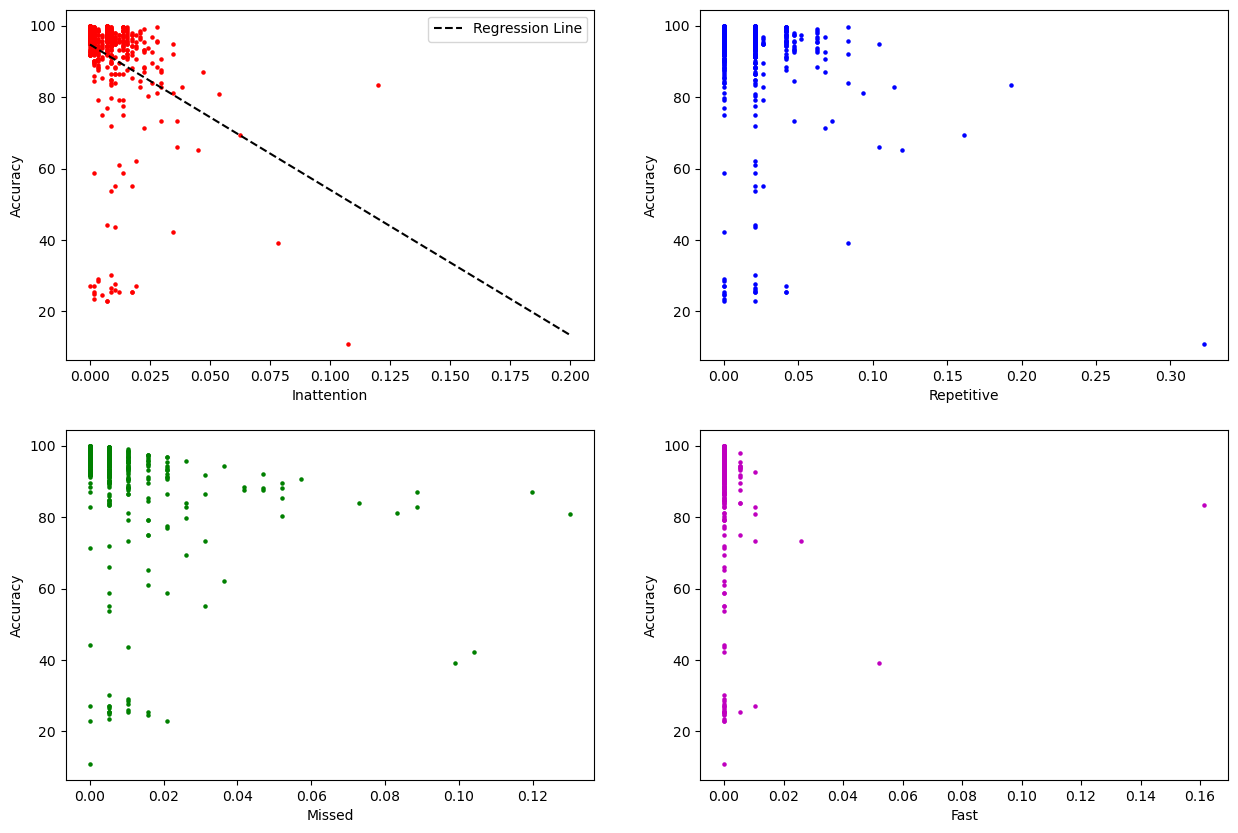

In [7]:
fig = plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.scatter(stroop_inattentive_df['Inattention'], stroop_inattentive_df['Accuracy'], s = 5, color='r')
b, a = np.polyfit(stroop_inattentive_df['Inattention'], stroop_inattentive_df['Accuracy'], deg=1)
x_seq = np.linspace(0, 0.2, 100)
plt.plot(x_seq, a + b*x_seq, 'k--', label='Regression Line')
plt.xlabel('Inattention')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 2)
plt.scatter(stroop_inattentive_df['Repetitive'], stroop_inattentive_df['Accuracy'], s = 5, color='b')
plt.xlabel('Repetitive')
plt.ylabel('Accuracy')

plt.subplot(2, 2, 3)
plt.scatter(stroop_inattentive_df['Missed'], stroop_inattentive_df['Accuracy'], s = 5, color='g')
plt.xlabel('Missed')
plt.ylabel('Accuracy')

plt.subplot(2, 2, 4)
plt.scatter(stroop_inattentive_df['Fast'], stroop_inattentive_df['Accuracy'], s = 5, color='m')
plt.xlabel('Fast')
plt.ylabel('Accuracy')

plt.show()

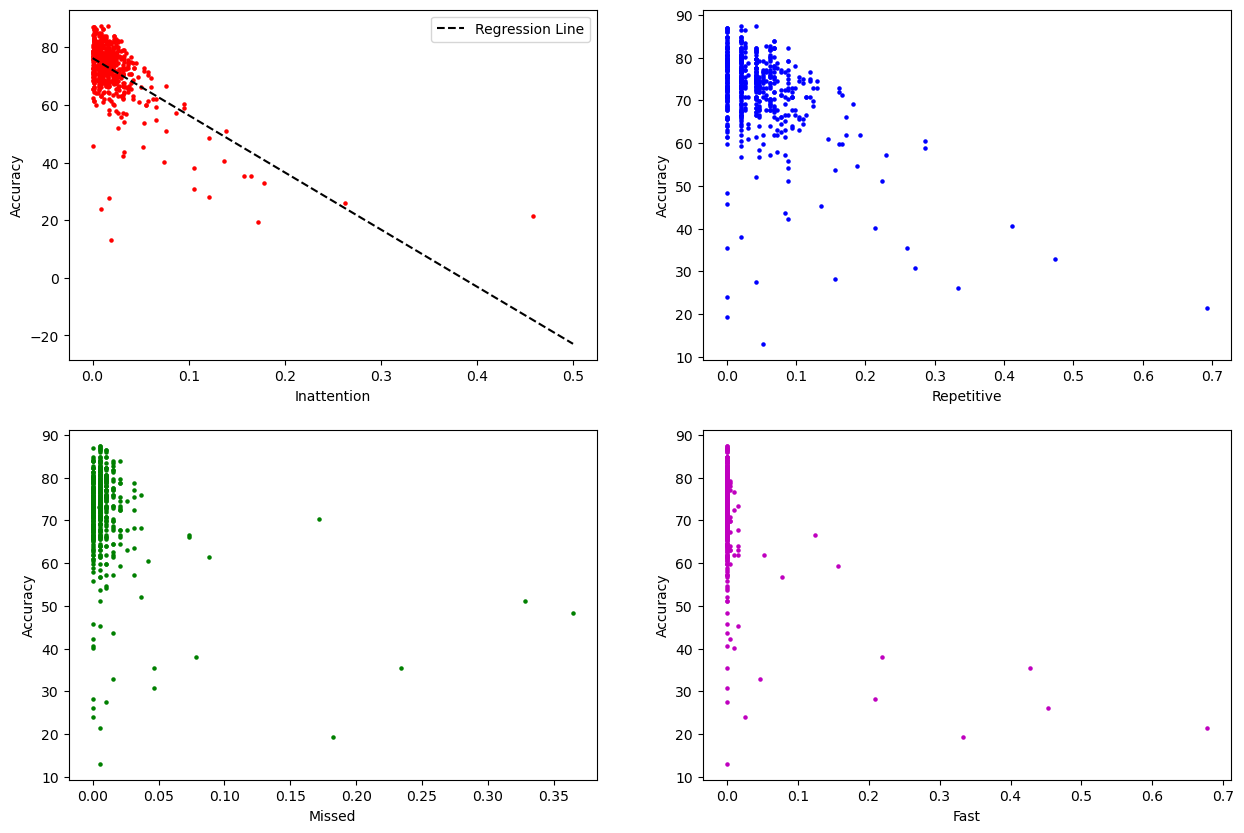

In [8]:
fig = plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.scatter(rdk_inattentive_df['Inattention'], rdk_inattentive_df['Accuracy'], s = 5, color='r')
b, a = np.polyfit(rdk_inattentive_df['Inattention'], rdk_inattentive_df['Accuracy'], deg=1)
x_seq = np.linspace(0, 0.5, 100)
plt.plot(x_seq, a + b*x_seq, 'k--', label='Regression Line')
plt.xlabel('Inattention')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 2)
plt.scatter(rdk_inattentive_df['Repetitive'], rdk_inattentive_df['Accuracy'], s = 5, color='b')
plt.xlabel('Repetitive')
plt.ylabel('Accuracy')

plt.subplot(2, 2, 3)
plt.scatter(rdk_inattentive_df['Missed'], rdk_inattentive_df['Accuracy'], s = 5, color='g')
plt.xlabel('Missed')
plt.ylabel('Accuracy')

plt.subplot(2, 2, 4)
plt.scatter(rdk_inattentive_df['Fast'], rdk_inattentive_df['Accuracy'], s = 5, color='m')
plt.xlabel('Fast')
plt.ylabel('Accuracy')

plt.show()

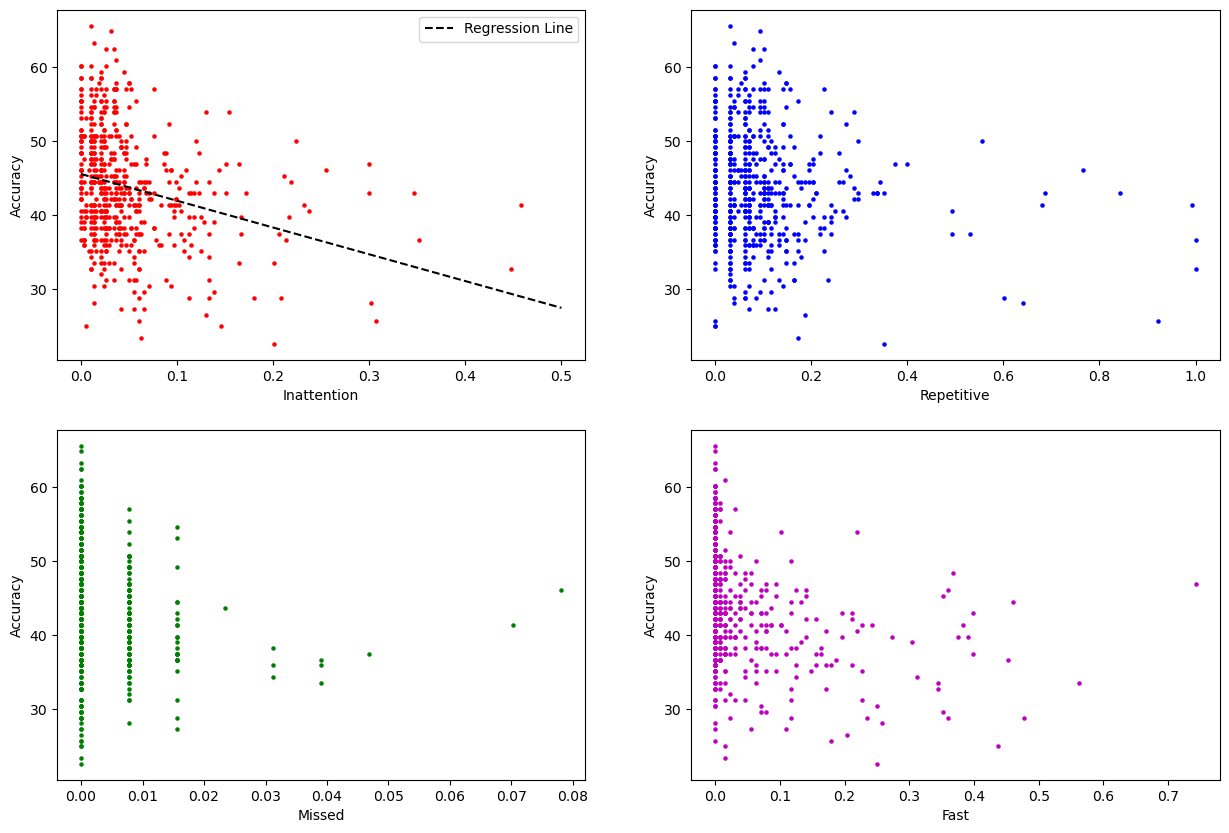

In [9]:
fig = plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.scatter(bandit_inattentive_df['Inattention'], bandit_inattentive_df['Accuracy'], s = 5, color='r')
b, a = np.polyfit(bandit_inattentive_df['Inattention'], bandit_inattentive_df['Accuracy'], deg=1)
x_seq = np.linspace(0, 0.5, 100)
plt.plot(x_seq, a + b*x_seq, 'k--', label='Regression Line')
plt.xlabel('Inattention')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 2)
plt.scatter(bandit_inattentive_df['Repetitive'], bandit_inattentive_df['Accuracy'], s = 5, color='b')
plt.xlabel('Repetitive')
plt.ylabel('Accuracy')

plt.subplot(2, 2, 3)
plt.scatter(bandit_inattentive_df['Missed'], bandit_inattentive_df['Accuracy'], s = 5, color='g')
plt.xlabel('Missed')
plt.ylabel('Accuracy')

plt.subplot(2, 2, 4)
plt.scatter(bandit_inattentive_df['Fast'], bandit_inattentive_df['Accuracy'], s = 5, color='m')
plt.xlabel('Fast')
plt.ylabel('Accuracy')

plt.show()

In [12]:
def sample_equal_rows(df, column, count):
    
    new_df = pd.DataFrame(columns=df.columns)
    for value in df[column].unique():
        new_df = new_df.append(df[df[column] == value].sample(count))
    return new_df

In [13]:
inattentive_df

,level_0,index,Participant,Task,Manipulation,Repetitive,Missed,Fast,Inattention,Accuracy
0,0,0,8283797.0,Stroop,stroop_vanilla,0.000000,0.005208,0.0,0.001736,89.583333
1,1,1,8283735.0,Stroop,stroop_vanilla,0.000000,0.000000,0.0,0.000000,96.354167
2,2,2,8283684.0,Stroop,stroop_vanilla,0.026042,0.015625,0.0,0.013889,79.166667
3,3,3,8283629.0,Stroop,stroop_vanilla,0.020833,0.000000,0.0,0.006944,95.312500
4,4,4,8296108.0,Stroop,stroop_vanilla,0.000000,0.000000,0.0,0.000000,99.479167
...,...,...,...,...,...,...,...,...,...,...
1635,544,544,8446310.0,Bandit,bandit_bonus,0.000000,0.000000,0.0,0.000000,46.093750
1636,545,545,8452653.0,Bandit,bandit_bonus,0.046875,0.007812,0.0,0.018229,44.531250
1637,546,546,8452682.0,Bandit,bandit_bonus,0.031250,0.000000,0.0,0.010417,46.875000
1638,547,547,8452722.0,Bandit,bandit_bonus,0.109375,0.000000,0.0,0.036458,53.906250


#### I. Comparing different tasks across manipulations

$H_0$: The mean performance of participants is statisitically similar for all three tasks (Stroop, RDK, bandit).

$H_a$: The mean performance of participants is significantly dissimilar for different tasks.

C:\Users\Devank\miniconda3\envs\noml\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 67.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Devank\miniconda3\envs\noml\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 49.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Devank\miniconda3\envs\noml\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 22.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Devank\miniconda3\envs\noml\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 72.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Devank\miniconda3\envs\noml\lib\site-packages\s

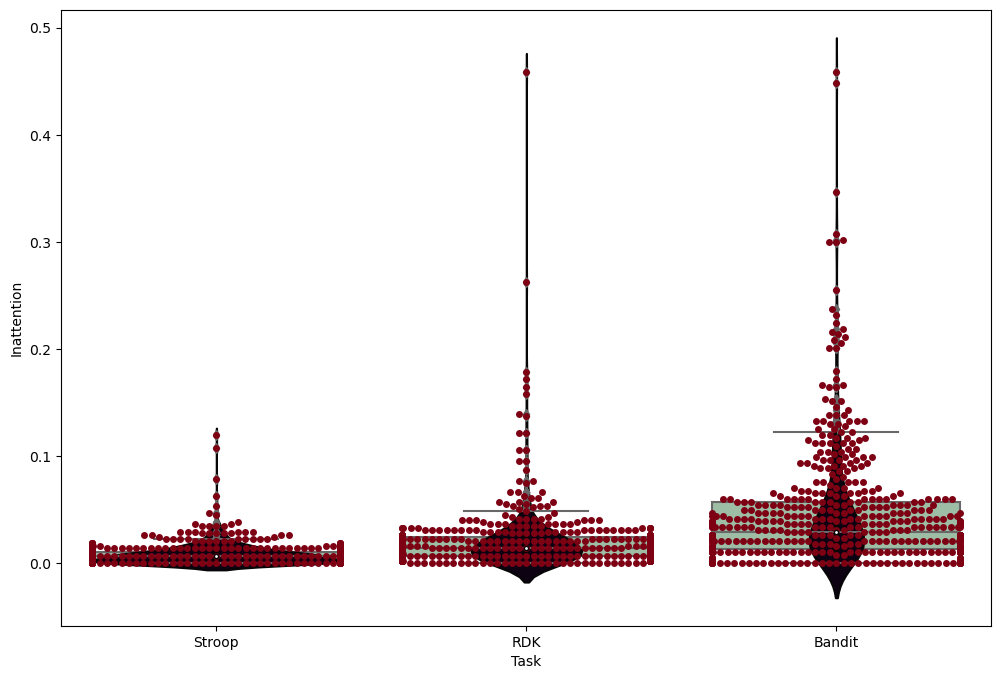

In [19]:
task_min_count = min(inattentive_df["Task"].value_counts())
task_performance_df = sample_equal_rows(inattentive_df, "Task", task_min_count)

fig = plt.figure(figsize=(12,8))
ax = sns.boxplot(x='Task', y='Inattention', data=task_performance_df, color='#99c2a2')
ax = sns.swarmplot(x="Task", y="Inattention", data=task_performance_df, color='#7d0013')
ax = sns.violinplot(x="Task", y="Inattention", data=task_performance_df, color='#0d0013')

plt.show()

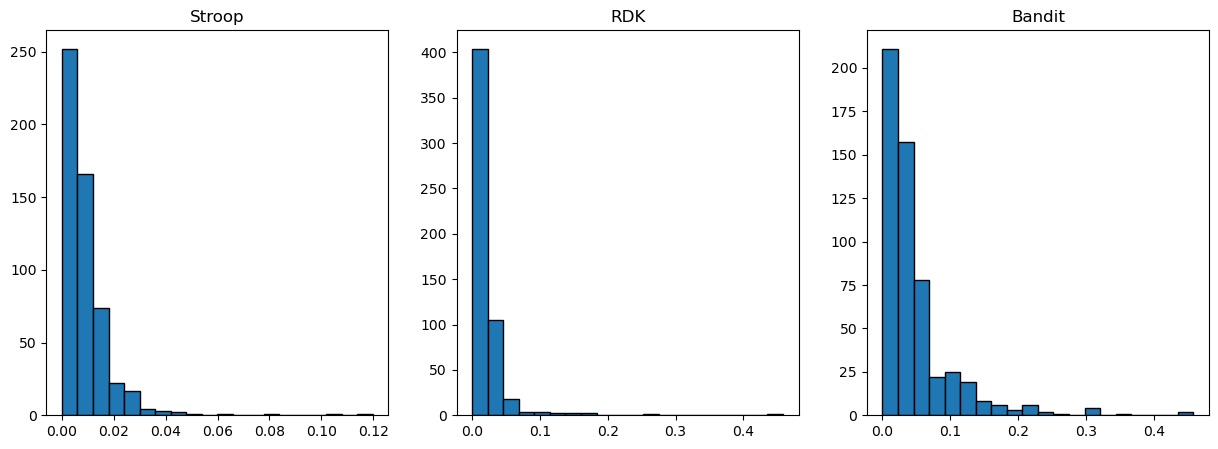

In [20]:
fig = plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
plt.hist(task_performance_df[task_performance_df["Task"] == "Stroop"]["Inattention"], edgecolor='black', bins=20)
plt.title("Stroop")
plt.subplot(1,3,2)
plt.hist(task_performance_df[task_performance_df["Task"] == "RDK"]["Inattention"], edgecolor='black', bins=20)
plt.title("RDK")
plt.subplot(1,3,3)
plt.hist(task_performance_df[task_performance_df["Task"] == "Bandit"]["Inattention"], edgecolor='black', bins=20)
plt.title("Bandit")
plt.show()

In [21]:
model1 = ols('Inattention ~ Task', data=task_performance_df).fit()
# test for normality - FAILED
print(stats.shapiro(model1.resid))

ShapiroResult(statistic=0.6098282933235168, pvalue=0.0)


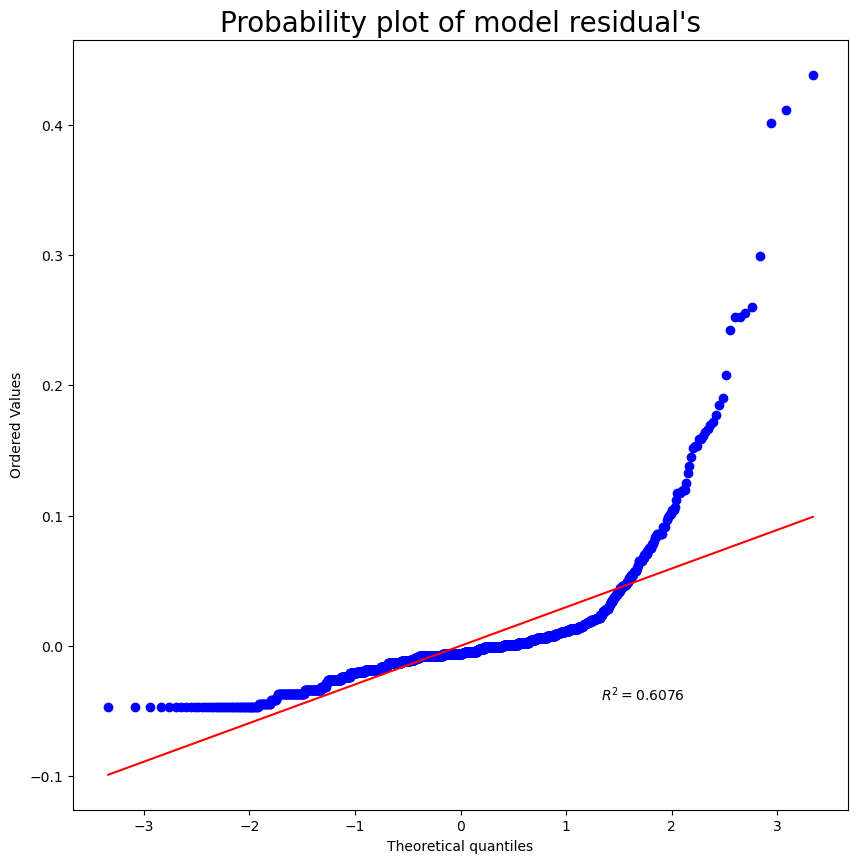

In [22]:
# another test for normality

fig = plt.figure(figsize= (10, 10))
ax = fig.add_subplot(111)

normality_plot, stat = stats.probplot(model1.resid, plot=plt, rvalue= True)
ax.set_title("Probability plot of model residual's", fontsize= 20)
ax.set

plt.show()

In [23]:
anova_table = sm.stats.anova_lm(model1, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
Task,0.432888,2.0,149.847432,1.793947e-60
Residual,2.357310,1632.0,NaN,NaN


#### II. Comparing different manipulations across tasks

$H_0$: The mean performance of participants is statisitically similar for all seven manipulations.

$H_a$: The mean performance of participants is significantly dissimilar for different manipulations.

C:\Users\Devank\miniconda3\envs\noml\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 37.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Devank\miniconda3\envs\noml\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 42.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Devank\miniconda3\envs\noml\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 36.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Devank\miniconda3\envs\noml\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 39.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Devank\miniconda3\envs\noml\lib\site-packages\s

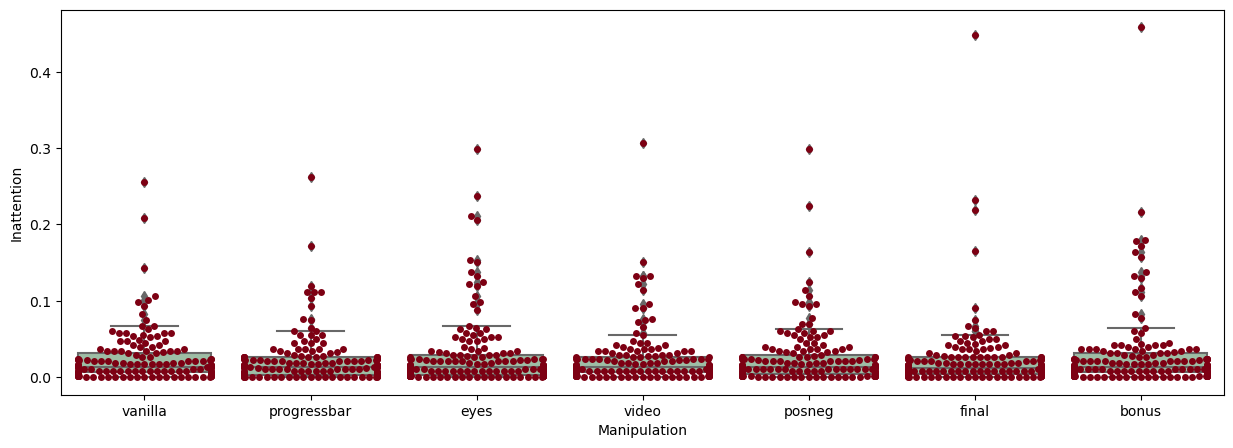

In [24]:
manip_performance_df = inattentive_df
manip_performance_df = manip_performance_df.replace('rdk_', '', regex=True)
manip_performance_df = manip_performance_df.replace('stroop_', '', regex=True)
manip_performance_df = manip_performance_df.replace('bandit_', '', regex=True)

manip_min_count = min(manip_performance_df["Manipulation"].value_counts())
manip_performance_df = sample_equal_rows(manip_performance_df, "Manipulation", manip_min_count)

fig = plt.figure(figsize=(15,5))
ax = sns.boxplot(x='Manipulation', y='Inattention', data=manip_performance_df, color='#99c2a2')
ax = sns.swarmplot(x="Manipulation", y="Inattention", data=manip_performance_df, color='#7d0013')
plt.show()

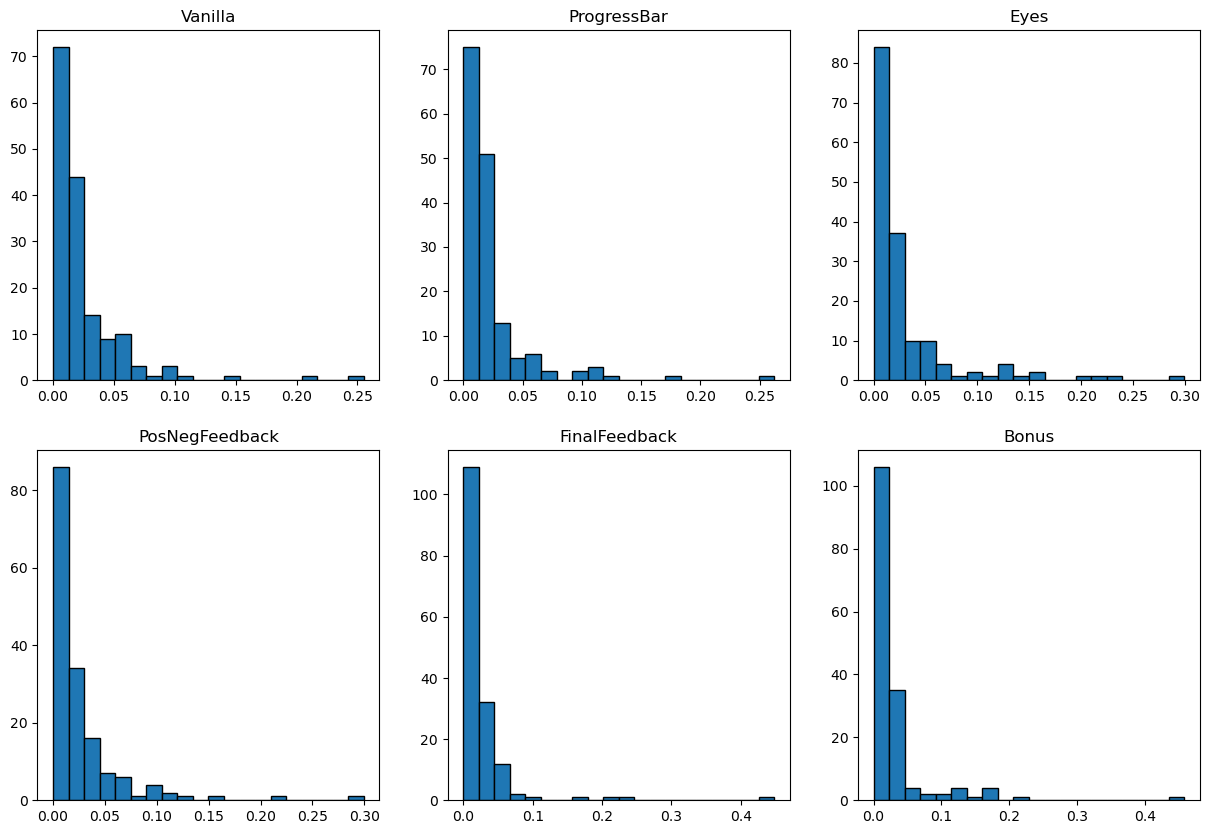

In [25]:
fig = plt.figure(figsize=(15, 10))
plt.subplot(2,3,1)
plt.hist(manip_performance_df[manip_performance_df["Manipulation"] == "vanilla"]["Inattention"], edgecolor='black', bins=20)
plt.title("Vanilla")
plt.subplot(2,3,2)
plt.hist(manip_performance_df[manip_performance_df["Manipulation"] == "progressbar"]["Inattention"], edgecolor='black', bins=20)
plt.title("ProgressBar")
plt.subplot(2,3,3)
plt.hist(manip_performance_df[manip_performance_df["Manipulation"] == "eyes"]["Inattention"], edgecolor='black', bins=20)
plt.title("Eyes")
plt.subplot(2,3,4)
plt.hist(manip_performance_df[manip_performance_df["Manipulation"] == "posneg"]["Inattention"], edgecolor='black', bins=20)
plt.title("PosNegFeedback")
plt.subplot(2,3,5)
plt.hist(manip_performance_df[manip_performance_df["Manipulation"] == "final"]["Inattention"], edgecolor='black', bins=20)
plt.title("FinalFeedback")
plt.subplot(2,3,6)
plt.hist(manip_performance_df[manip_performance_df["Manipulation"] == "bonus"]["Inattention"], edgecolor='black', bins=20)
plt.title("Bonus")
plt.show()

In [26]:
model2 = ols('Inattention ~ Manipulation', data=manip_performance_df).fit()
print(stats.shapiro(model2.resid))

ShapiroResult(statistic=0.5640280246734619, pvalue=0.0)


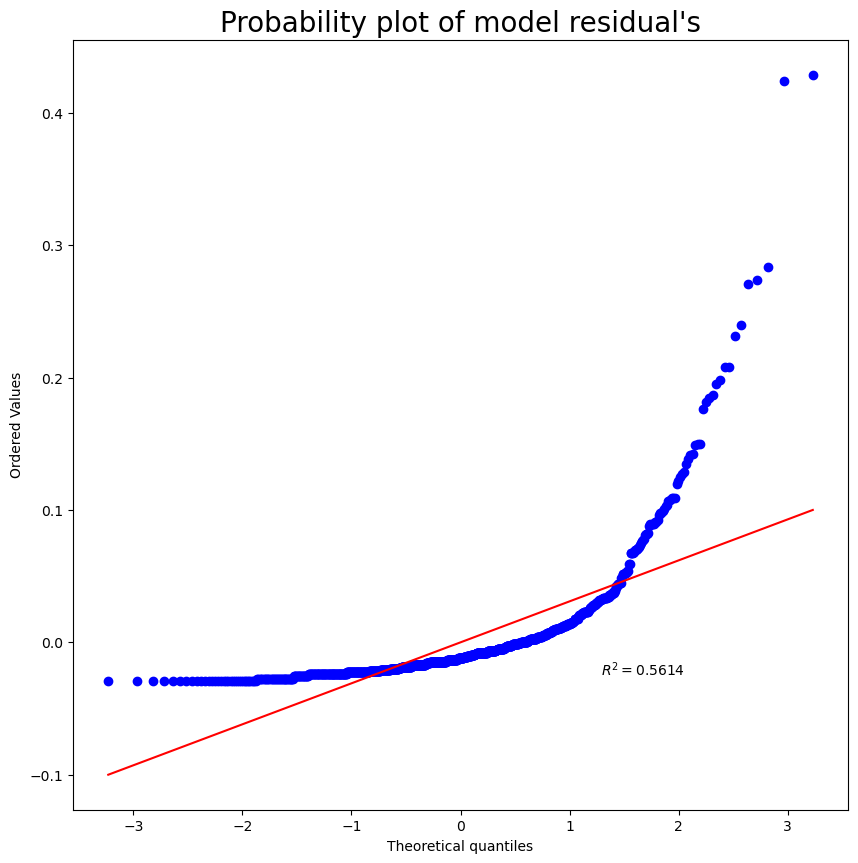

In [27]:
# another test for normality

fig = plt.figure(figsize= (10, 10))
ax = fig.add_subplot(111)

normality_plot, stat = stats.probplot(model2.resid, plot=plt, rvalue= True)
ax.set_title("Probability plot of model residual's", fontsize= 20)
ax.set

plt.show()

In [28]:
anova_table = sm.stats.anova_lm(model2, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
Manipulation,0.007712,6.0,0.75173,0.608093
Residual,1.903107,1113.0,NaN,NaN


### WITHIN TASK ANOVAs

#### I. Stroop

C:\Users\Devank\miniconda3\envs\noml\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 5.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Devank\miniconda3\envs\noml\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 6.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Devank\miniconda3\envs\noml\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 8.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Devank\miniconda3\envs\noml\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 13.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


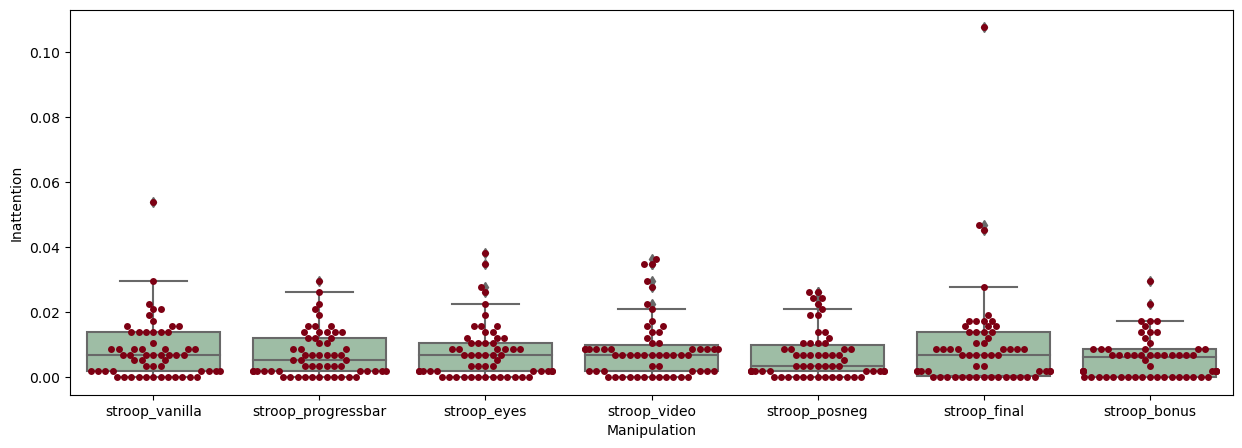

In [31]:
stroop_performance_df = inattentive_df[inattentive_df["Task"] == "Stroop"]
stroop_performance_df = sample_equal_rows(stroop_performance_df, "Manipulation", min(stroop_performance_df["Manipulation"].value_counts()))

fig = plt.figure(figsize=(15,5))
ax = sns.boxplot(x='Manipulation', y='Inattention', data=stroop_performance_df, color='#99c2a2')
ax = sns.swarmplot(x="Manipulation", y="Inattention", data=stroop_performance_df, color='#7d0013')
plt.show()

In [32]:
model3 = ols('Inattention ~ Manipulation', data=stroop_performance_df).fit()
print(stats.shapiro(model3.resid))

ShapiroResult(statistic=0.7445598840713501, pvalue=1.5144163144437163e-24)


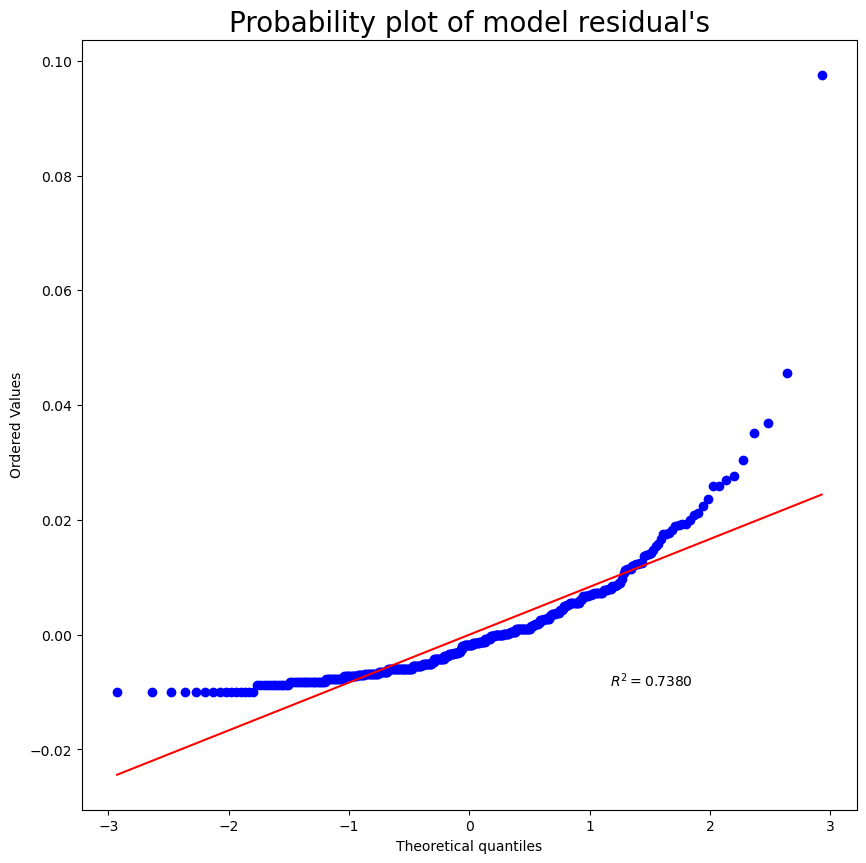

In [33]:
# another test for normality

fig = plt.figure(figsize= (10, 10))
ax = fig.add_subplot(111)

normality_plot, stat = stats.probplot(model3.resid, plot=plt, rvalue= True)
ax.set_title("Probability plot of model residual's", fontsize= 20)
ax.set

plt.show()

In [34]:
anova_table = sm.stats.anova_lm(model3, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
Manipulation,0.000644,6.0,1.132988,0.34222
Residual,0.037772,399.0,NaN,NaN


#### II. RDK

C:\Users\Devank\miniconda3\envs\noml\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 9.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Devank\miniconda3\envs\noml\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 5.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


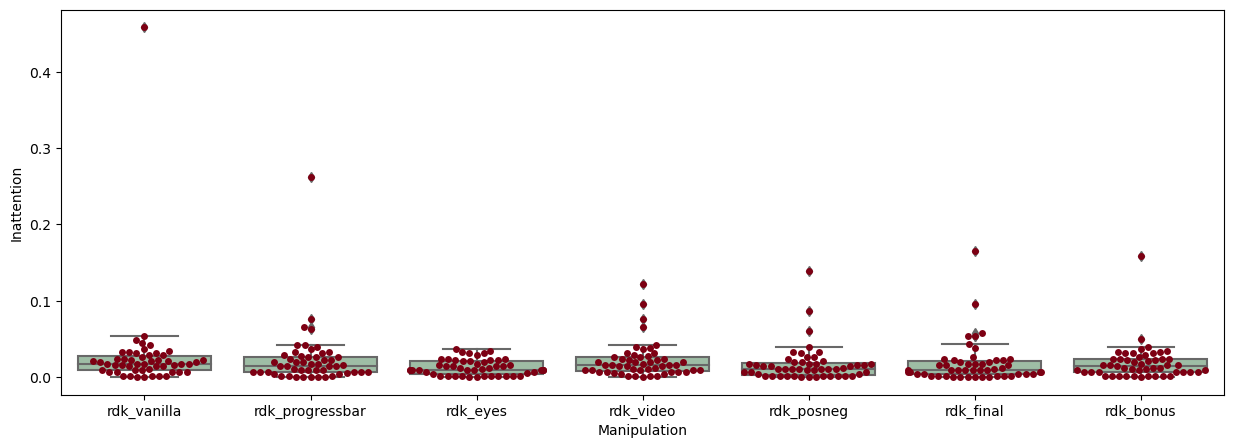

In [35]:
rdk_performance_df = inattentive_df[inattentive_df["Task"] == "RDK"]
rdk_performance_df = sample_equal_rows(rdk_performance_df, "Manipulation", min(rdk_performance_df["Manipulation"].value_counts()))

fig = plt.figure(figsize=(15,5))
ax = sns.boxplot(x='Manipulation', y='Inattention', data=rdk_performance_df, color='#99c2a2')
ax = sns.swarmplot(x="Manipulation", y="Inattention", data=rdk_performance_df, color='#7d0013')
plt.show()

In [36]:
model4 = ols('Inattention ~ Manipulation', data=rdk_performance_df).fit()
print(stats.shapiro(model4.resid))

ShapiroResult(statistic=0.44316375255584717, pvalue=9.039077245852834e-32)


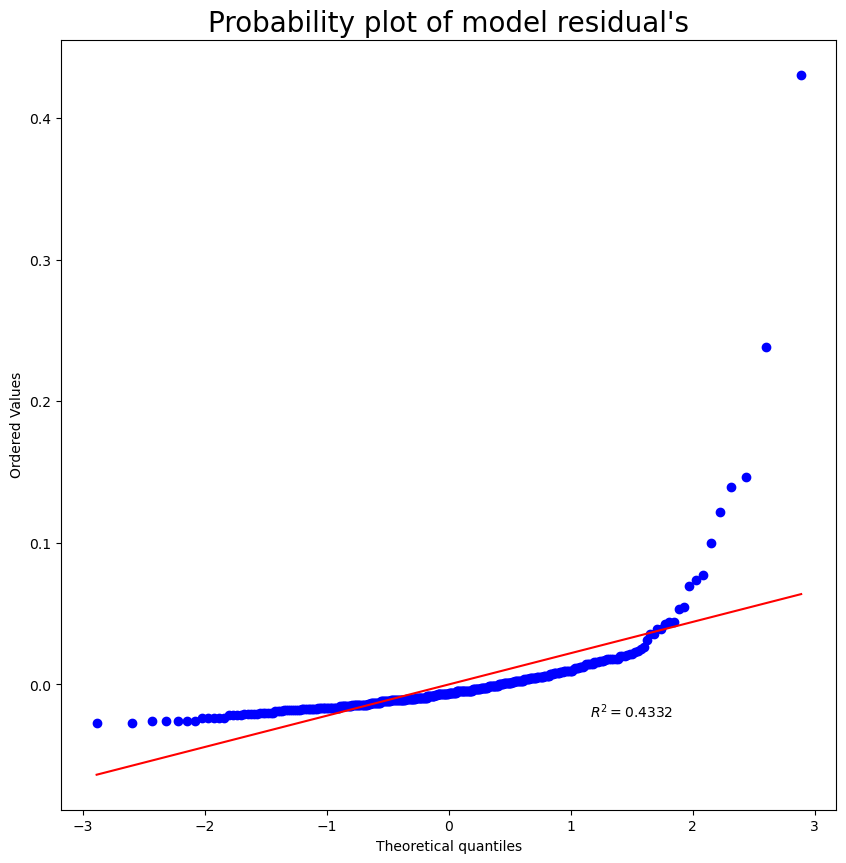

In [37]:
# another test for normality

fig = plt.figure(figsize= (10, 10))
ax = fig.add_subplot(111)

normality_plot, stat = stats.probplot(model4.resid, plot=plt, rvalue= True)
ax.set_title("Probability plot of model residual's", fontsize= 20)
ax.set

plt.show()

In [38]:
anova_table = sm.stats.anova_lm(model4, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
Manipulation,0.006885,6.0,1.011678,0.417356
Residual,0.396965,350.0,NaN,NaN


#### III. Bandit

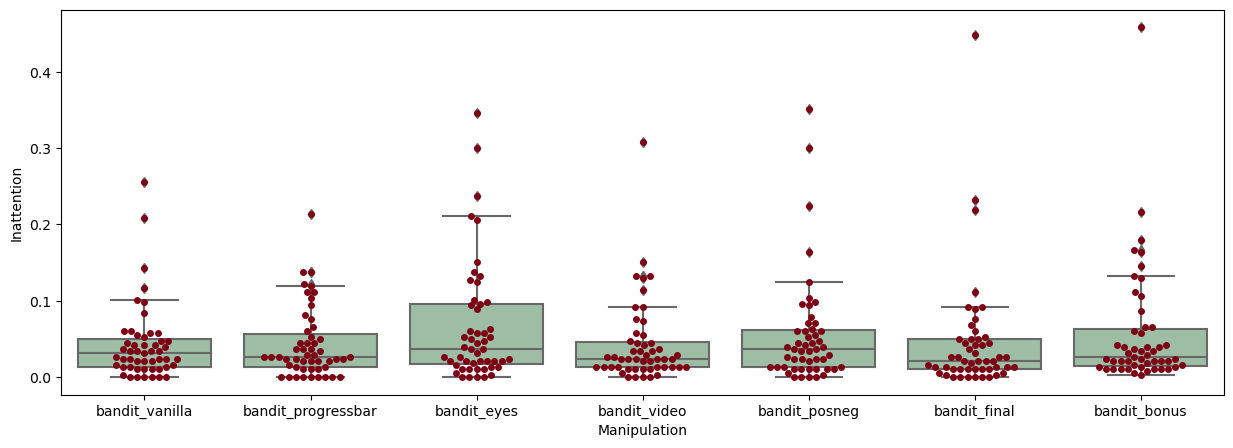

In [39]:
bandit_performance_df = inattentive_df[inattentive_df["Task"] == "Bandit"]
bandit_performance_df = sample_equal_rows(bandit_performance_df, "Manipulation", min(bandit_performance_df["Manipulation"].value_counts()))

fig = plt.figure(figsize=(15,5))
ax = sns.boxplot(x='Manipulation', y='Inattention', data=bandit_performance_df, color='#99c2a2')
ax = sns.swarmplot(x="Manipulation", y="Inattention", data=bandit_performance_df, color='#7d0013')
plt.show()

In [40]:
model5 = ols('Inattention ~ Manipulation', data=bandit_performance_df).fit()
print(stats.shapiro(model5.resid))

ShapiroResult(statistic=0.6999285221099854, pvalue=9.22459528508461e-25)


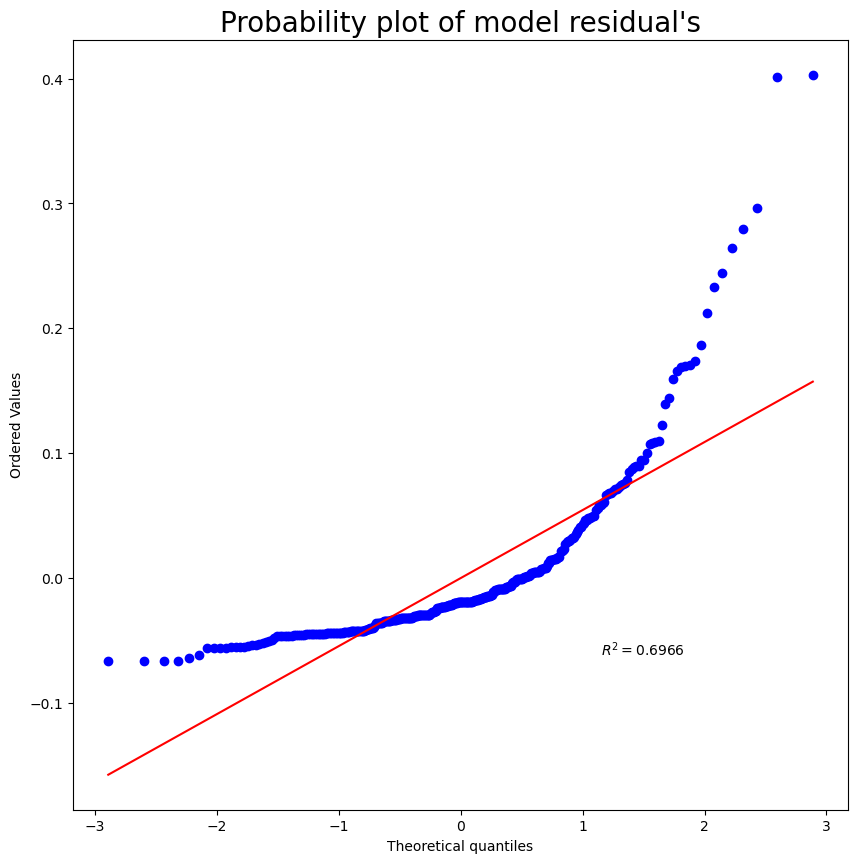

In [41]:
# another test for normality

fig = plt.figure(figsize= (10, 10))
ax = fig.add_subplot(111)

normality_plot, stat = stats.probplot(model5.resid, plot=plt, rvalue= True)
ax.set_title("Probability plot of model residual's", fontsize= 20)
ax.set

plt.show()

In [42]:
anova_table = sm.stats.anova_lm(model5, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
Manipulation,0.026396,6.0,1.026051,0.40796
Residual,1.500665,350.0,NaN,NaN


## Permutation Tests

Let's see how this goes.

In [43]:
def statistic(x, y):
    return (np.mean(x) - np.mean(y))

In [44]:
# comparing between two tasks

x = np.asarray(inattentive_df[inattentive_df["Task"] == "Stroop"][["Inattention"]])
y = np.asarray(inattentive_df[inattentive_df["Task"] == "RDK"][["Inattention"]])
z = np.asarray(inattentive_df[inattentive_df["Task"] == "Bandit"][["Inattention"]])

print(statistic(x, y))
print(statistic(y, z))
print(statistic(z, x))


-0.011906018031460705
-0.027553057160196452
0.03945907519165716


In [45]:
res = stats.permutation_test((x, y), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-0.01190602]
[0.00019998]


In [46]:
res = stats.permutation_test((y, z), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-0.02755306]
[0.00019998]


In [47]:
res = stats.permutation_test((z, x), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[0.03945908]
[0.00019998]


In [48]:
manip_1 = inattentive_df[inattentive_df["Manipulation"].str.contains("vanilla")]
manip_2 = inattentive_df[inattentive_df["Manipulation"].str.contains("progress")]
manip_3 = inattentive_df[inattentive_df["Manipulation"].str.contains("eyes")]
manip_4 = inattentive_df[inattentive_df["Manipulation"].str.contains("posneg")]
manip_5 = inattentive_df[inattentive_df["Manipulation"].str.contains("final")]
manip_6 = inattentive_df[inattentive_df["Manipulation"].str.contains("bonus")]
manip_7 = inattentive_df[inattentive_df["Manipulation"].str.contains("video")]

##### Stroop

In [50]:
str_manip_1 = manip_1[manip_1["Task"] == "Stroop"][["Inattention"]]
str_manip_2 = manip_2[manip_2["Task"] == "Stroop"][["Inattention"]]
str_manip_3 = manip_3[manip_3["Task"] == "Stroop"][["Inattention"]]
str_manip_4 = manip_4[manip_4["Task"] == "Stroop"][["Inattention"]]
str_manip_5 = manip_5[manip_5["Task"] == "Stroop"][["Inattention"]]
str_manip_6 = manip_6[manip_6["Task"] == "Stroop"][["Inattention"]]
str_manip_7 = manip_7[manip_7["Task"] == "Stroop"][["Inattention"]]

print(len(str_manip_7))

58


In [51]:
# vanilla vs progress-bar
res = stats.permutation_test((str_manip_1, str_manip_2), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[0.00065731]
[0.59994001]


In [52]:
# vanilla vs eyes
res = stats.permutation_test((str_manip_1, str_manip_3), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-0.00168519]
[0.44275572]


In [53]:
# vanilla vs posneg
res = stats.permutation_test((str_manip_1, str_manip_4), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[0.00057735]
[0.66033397]


In [54]:
# vanilla vs final
res = stats.permutation_test((str_manip_1, str_manip_5), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-0.00198976]
[0.31976802]


In [55]:
# vanilla vs bonus
res = stats.permutation_test((str_manip_1, str_manip_6), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[0.00052717]
[0.73612639]


In [56]:
# vanilla vs video
res = stats.permutation_test((str_manip_1, str_manip_7), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-0.00098286]
[0.53494651]


In [57]:
# progress-bar vs eyes
res = stats.permutation_test((str_manip_2, str_manip_3), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-0.0023425]
[0.24017598]


In [58]:
# progress-bar vs posneg
res = stats.permutation_test((str_manip_2, str_manip_4), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-7.99633323e-05]
[0.96810319]


In [59]:
# progress-bar vs final
res = stats.permutation_test((str_manip_2, str_manip_5), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-0.00264707]
[0.1789821]


In [60]:
# progress-bar vs bonus
res = stats.permutation_test((str_manip_2, str_manip_6), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-0.00013014]
[0.95810419]


In [61]:
# progress-bar vs video
res = stats.permutation_test((str_manip_2, str_manip_7), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-0.00164017]
[0.25177482]


In [62]:
# eyes vs posneg
res = stats.permutation_test((str_manip_3, str_manip_4), statistic, vectorized=False, n_resamples=1e4)#, alternative='less')
print(res.statistic)
print(res.pvalue)

[0.00226254]
[0.25237476]


In [63]:
# eyes vs final
res = stats.permutation_test((str_manip_3, str_manip_5), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-0.00030457]
[0.93850615]


In [64]:
# eyes vs bonus
res = stats.permutation_test((str_manip_3, str_manip_6), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[0.00221236]
[0.2939706]


In [65]:
# eyes vs video
res = stats.permutation_test((str_manip_3, str_manip_7), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[0.00070233]
[0.83151685]


In [66]:
# posneg vs final
res = stats.permutation_test((str_manip_4, str_manip_5), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-0.00256711]
[0.1879812]


In [67]:
# posneg vs bonus
res = stats.permutation_test((str_manip_4, str_manip_6), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-5.01795368e-05]
[0.98130187]


In [68]:
# posneg vs video
res = stats.permutation_test((str_manip_4, str_manip_7), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-0.00156021]
[0.29737026]


In [69]:
# final vs bonus
res = stats.permutation_test((str_manip_5, str_manip_6), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[0.00251693]
[0.21857814]


In [70]:
# final vs video
res = stats.permutation_test((str_manip_5, str_manip_7), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[0.0010069]
[0.70552945]


In [71]:
# bonus vs video
res = stats.permutation_test((str_manip_6, str_manip_7), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-0.00151003]
[0.39876012]


##### Bandit

In [72]:
bandit_manip_1 = manip_1[manip_1["Task"] == "Bandit"][["Inattention"]]
bandit_manip_2 = manip_2[manip_2["Task"] == "Bandit"][["Inattention"]]
bandit_manip_3 = manip_3[manip_3["Task"] == "Bandit"][["Inattention"]]
bandit_manip_4 = manip_4[manip_4["Task"] == "Bandit"][["Inattention"]]
bandit_manip_5 = manip_5[manip_5["Task"] == "Bandit"][["Inattention"]]
bandit_manip_6 = manip_6[manip_6["Task"] == "Bandit"][["Inattention"]]
bandit_manip_7 = manip_7[manip_7["Task"] == "Bandit"][["Inattention"]]

print(len(bandit_manip_7))

51


In [73]:
# vanilla vs progress-bar
res = stats.permutation_test((bandit_manip_1, bandit_manip_2), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-0.0014823]
[0.85971403]


In [74]:
# vanilla vs eyes
res = stats.permutation_test((bandit_manip_1, bandit_manip_3), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-0.01989207]
[0.02959704]


In [75]:
# vanilla vs posneg
res = stats.permutation_test((bandit_manip_1, bandit_manip_4), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-0.00970766]
[0.25057494]


In [76]:
# vanilla vs final
res = stats.permutation_test((bandit_manip_1, bandit_manip_5), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-0.00568345]
[0.53354665]


In [77]:
# vanilla vs bonus
res = stats.permutation_test((bandit_manip_1, bandit_manip_6), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-0.00692353]
[0.43935606]


In [78]:
# vanilla vs video
res = stats.permutation_test((bandit_manip_1, bandit_manip_7), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-0.00202157]
[0.79992001]


In [79]:
# progress-bar vs eyes
res = stats.permutation_test((bandit_manip_2, bandit_manip_3), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-0.01840977]
[0.04279572]


In [80]:
# progress-bar vs posneg
res = stats.permutation_test((bandit_manip_2, bandit_manip_4), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-0.00822536]
[0.30936906]


In [81]:
# progress-bar vs final
res = stats.permutation_test((bandit_manip_2, bandit_manip_5), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-0.00420115]
[0.64193581]


In [82]:
# progress-bar vs bonus
res = stats.permutation_test((bandit_manip_2, bandit_manip_6), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-0.00544123]
[0.53314669]


In [83]:
# progress-bar vs video
res = stats.permutation_test((bandit_manip_2, bandit_manip_7), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-0.00053927]
[0.93290671]


In [84]:
# eyes vs posneg
res = stats.permutation_test((bandit_manip_3, bandit_manip_4), statistic, vectorized=False, n_resamples=1e4)#, alternative='less')
print(res.statistic)
print(res.pvalue)

[0.01018441]
[0.32476752]


In [85]:
# eyes vs final
res = stats.permutation_test((bandit_manip_3, bandit_manip_5), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[0.01420862]
[0.18678132]


In [86]:
# eyes vs bonus
res = stats.permutation_test((bandit_manip_3, bandit_manip_6), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[0.01296854]
[0.22517748]


In [87]:
# eyes vs video
res = stats.permutation_test((bandit_manip_3, bandit_manip_7), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[0.0178705]
[0.11638836]


In [88]:
# posneg vs final
res = stats.permutation_test((bandit_manip_4, bandit_manip_5), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[0.00402421]
[0.70432957]


In [89]:
# posneg vs bonus
res = stats.permutation_test((bandit_manip_4, bandit_manip_6), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[0.00278413]
[0.77232277]


In [90]:
# posneg vs video
res = stats.permutation_test((bandit_manip_4, bandit_manip_7), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[0.00768609]
[0.4819518]


In [91]:
# final vs bonus
res = stats.permutation_test((bandit_manip_5, bandit_manip_6), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-0.00124008]
[0.89331067]


In [92]:
# final vs video
res = stats.permutation_test((bandit_manip_5, bandit_manip_7), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[0.00366188]
[0.75992401]


In [93]:
# bonus vs video
res = stats.permutation_test((bandit_manip_6, bandit_manip_7), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[0.00490196]
[0.69633037]


##### Manipulation-wise permutations (task-agnostic)

In [94]:
#re-doing this assignment for readability

manip_1 = inattentive_df[inattentive_df["Manipulation"].str.contains("vanilla")][["Inattention"]]
manip_2 = inattentive_df[inattentive_df["Manipulation"].str.contains("progress")][["Inattention"]]
manip_3 = inattentive_df[inattentive_df["Manipulation"].str.contains("eyes")][["Inattention"]]
manip_4 = inattentive_df[inattentive_df["Manipulation"].str.contains("posneg")][["Inattention"]]
manip_5 = inattentive_df[inattentive_df["Manipulation"].str.contains("final")][["Inattention"]]
manip_6 = inattentive_df[inattentive_df["Manipulation"].str.contains("bonus")][["Inattention"]]
manip_7 = inattentive_df[inattentive_df["Manipulation"].str.contains("video")][["Inattention"]]

print(manip_3.head())

     Inattention
157     0.001736
158     0.000000
159     0.008681
160     0.003472
161     0.003472


In [95]:
# vanilla vs progress-bar
res = stats.permutation_test((manip_1, manip_2), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[0.00091409]
[0.80251975]


In [96]:
# vanilla vs eyes
res = stats.permutation_test((manip_1, manip_3), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-0.00413645]
[0.31976802]


In [97]:
# vanilla vs posneg
res = stats.permutation_test((manip_1, manip_4), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[9.17417488e-05]
[0.97370263]


In [98]:
# vanilla vs final
res = stats.permutation_test((manip_1, manip_5), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-0.0004269]
[0.90610939]


In [99]:
# vanilla vs bonus
res = stats.permutation_test((manip_1, manip_6), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-0.00127875]
[0.76672333]


In [100]:
# vanilla vs video
res = stats.permutation_test((manip_1, manip_7), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[0.0009159]
[0.83731627]


In [101]:
# progress-bar vs eyes
res = stats.permutation_test((manip_2, manip_3), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-0.00505054]
[0.1749825]


In [102]:
# progress-bar vs posneg
res = stats.permutation_test((manip_2, manip_4), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-0.00082235]
[0.80271973]


In [103]:
# progress-bar vs final
res = stats.permutation_test((manip_2, manip_5), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-0.00134099]
[0.69673033]


In [104]:
# progress-bar vs bonus
res = stats.permutation_test((manip_2, manip_6), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-0.00219284]
[0.54934507]


In [105]:
# progress-bar vs video
res = stats.permutation_test((manip_2, manip_7), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[1.81112627e-06]
[0.98610139]


In [106]:
# eyes vs posneg
res = stats.permutation_test((manip_3, manip_4), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[0.00422819]
[0.31456854]


In [107]:
# eyes vs final
res = stats.permutation_test((manip_3, manip_5), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[0.00370954]
[0.37076292]


In [108]:
# eyes vs bonus
res = stats.permutation_test((manip_3, manip_6), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[0.0028577]
[0.50354965]


In [109]:
# eyes vs video
res = stats.permutation_test((manip_3, manip_7), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[0.00505235]
[0.26217378]


In [110]:
# posneg vs final
res = stats.permutation_test((manip_4, manip_5), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-0.00051865]
[0.90510949]


In [111]:
# posneg vs bonus
res = stats.permutation_test((manip_4, manip_6), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-0.00137049]
[0.71972803]


In [112]:
# posneg vs video
res = stats.permutation_test((manip_4, manip_7), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[0.00082416]
[0.83311669]


In [113]:
# final vs bonus
res = stats.permutation_test((manip_5, manip_6), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-0.00085184]
[0.84331567]


In [114]:
# final vs video
res = stats.permutation_test((manip_5, manip_7), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[0.00134281]
[0.78292171]


In [115]:
# bonus vs video
res = stats.permutation_test((manip_6, manip_7), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[0.00219465]
[0.60713929]


## Performance across days

0.004743811292853556


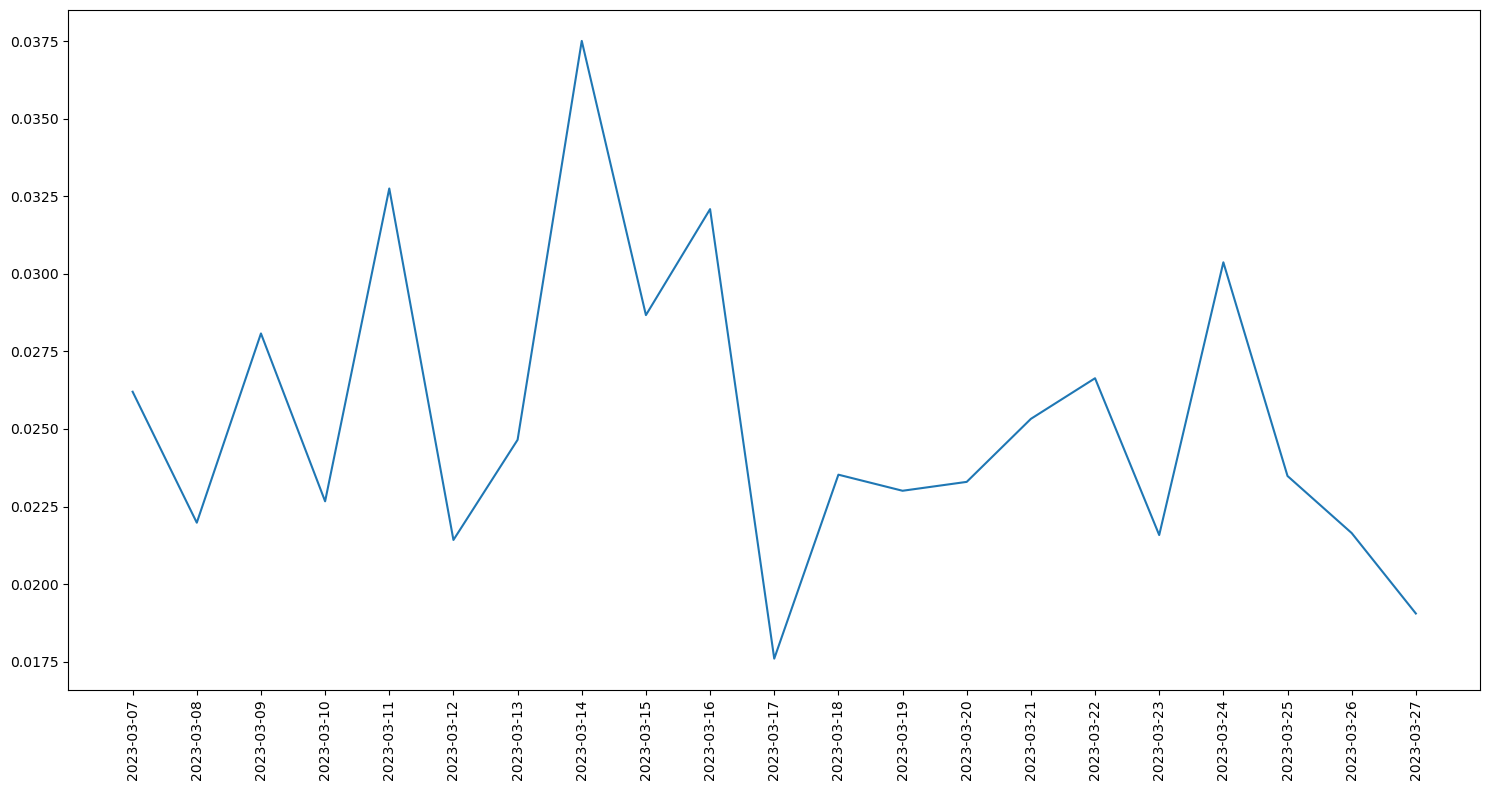

In [7]:
# overall

fig = plt.figure(figsize=(15, 8))
inattentive_df_grouped = inattentive_df.groupby([inattentive_df['Date'].dt.date])['Inattention'].mean().reset_index()
inattentive_df_grouped['Date'] = pd.to_datetime(inattentive_df_grouped['Date'])
plt.plot(inattentive_df_grouped['Date'], inattentive_df_grouped['Inattention'])
# plt.plot(inattentive_df_grouped['Date'], inattentive_df_grouped['Inattention'] + np.std(inattentive_df_grouped['Inattention']), 'k--', alpha = 0.3)
# plt.plot(inattentive_df_grouped['Date'], inattentive_df_grouped['Inattention'] - np.std(inattentive_df_grouped['Inattention']), 'k--', alpha = 0.3)
plt.xticks(inattentive_df_grouped['Date'], rotation=90)
fig.tight_layout()
print(np.std(inattentive_df_grouped['Inattention']))

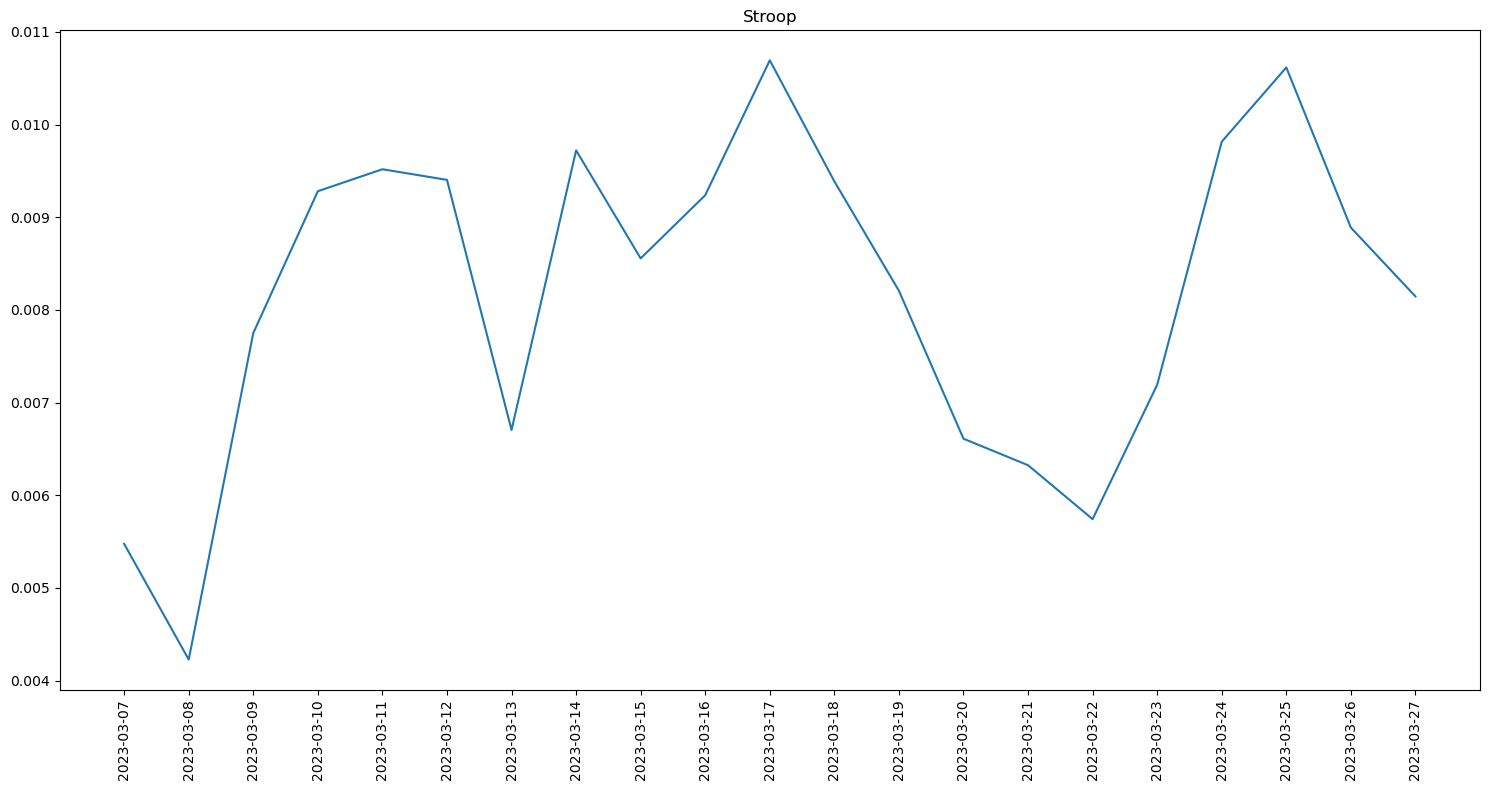

In [8]:
# stroop

fig = plt.figure(figsize=(15, 8))
stroop_inattentive_df_grouped = stroop_inattentive_df.groupby([stroop_inattentive_df['Date'].dt.date])['Inattention'].mean().reset_index()
stroop_inattentive_df_grouped['Date'] = pd.to_datetime(stroop_inattentive_df_grouped['Date'])
plt.plot(stroop_inattentive_df_grouped['Date'], stroop_inattentive_df_grouped['Inattention'])
# plt.plot(stroop_inattentive_df_grouped['Date'], stroop_inattentive_df_grouped['Inattention'] + np.std(stroop_inattentive_df_grouped['Inattention']), 'k--', alpha = 0.3)
# plt.plot(stroop_inattentive_df_grouped['Date'], stroop_inattentive_df_grouped['Inattention'] - np.std(stroop_inattentive_df_grouped['Inattention']), 'k--', alpha = 0.3)
plt.xticks(stroop_inattentive_df_grouped['Date'], rotation=90)
plt.title("Stroop")
fig.tight_layout()


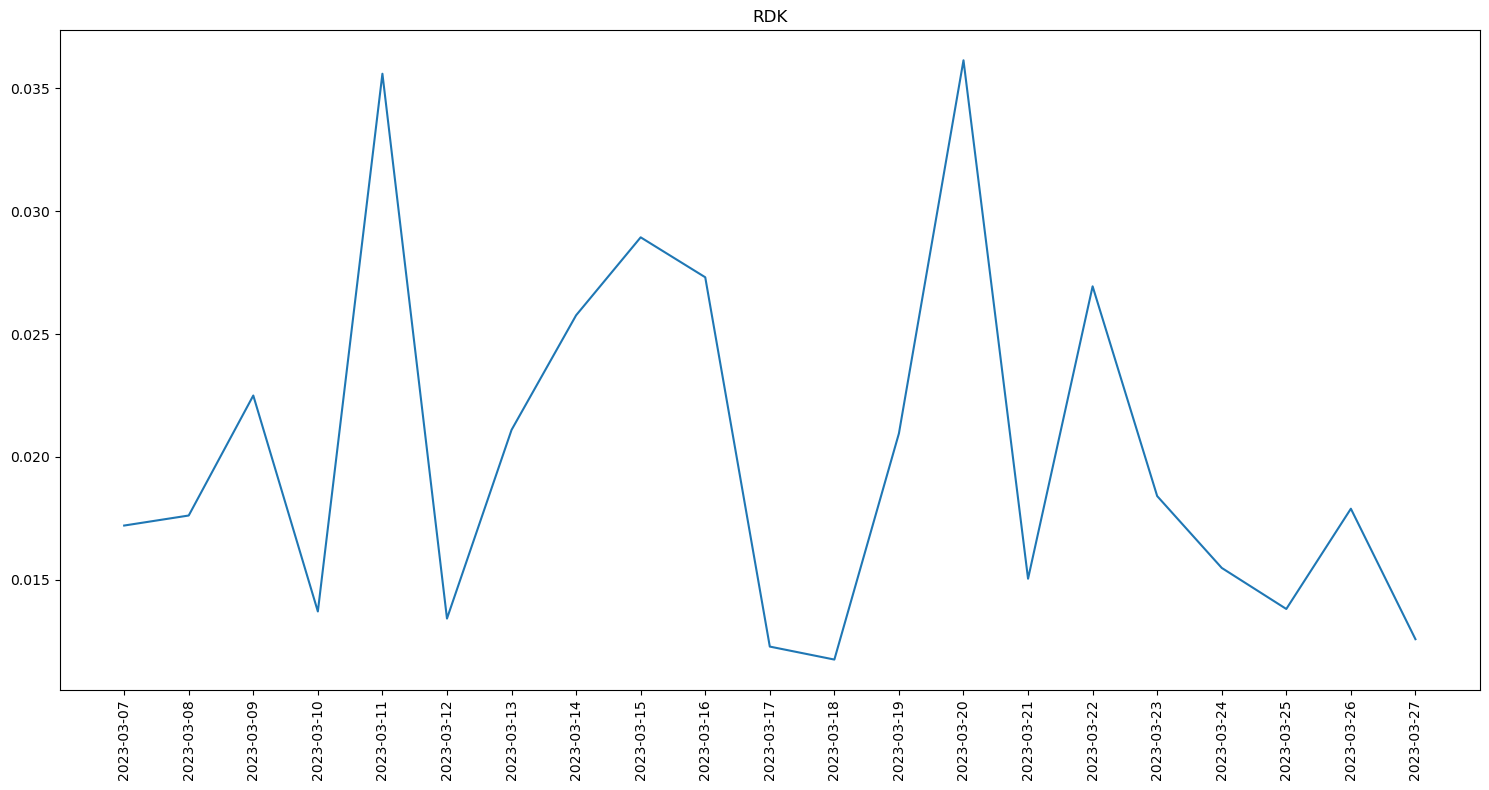

In [9]:
# rdk

fig = plt.figure(figsize=(15, 8))
rdk_inattentive_df_grouped = rdk_inattentive_df.groupby([rdk_inattentive_df['Date'].dt.date])['Inattention'].mean().reset_index()
rdk_inattentive_df_grouped['Date'] = pd.to_datetime(rdk_inattentive_df_grouped['Date'])
plt.plot(rdk_inattentive_df_grouped['Date'], rdk_inattentive_df_grouped['Inattention'])
# plt.plot(rdk_inattentive_df_grouped['Date'], rdk_inattentive_df_grouped['Inattention'] + np.std(rdk_inattentive_df_grouped['Inattention']), 'k--', alpha = 0.3)
# plt.plot(rdk_inattentive_df_grouped['Date'], rdk_inattentive_df_grouped['Inattention'] - np.std(rdk_inattentive_df_grouped['Inattention']), 'k--', alpha = 0.3)
plt.xticks(rdk_inattentive_df_grouped['Date'], rotation=90)
plt.title("RDK")
fig.tight_layout()


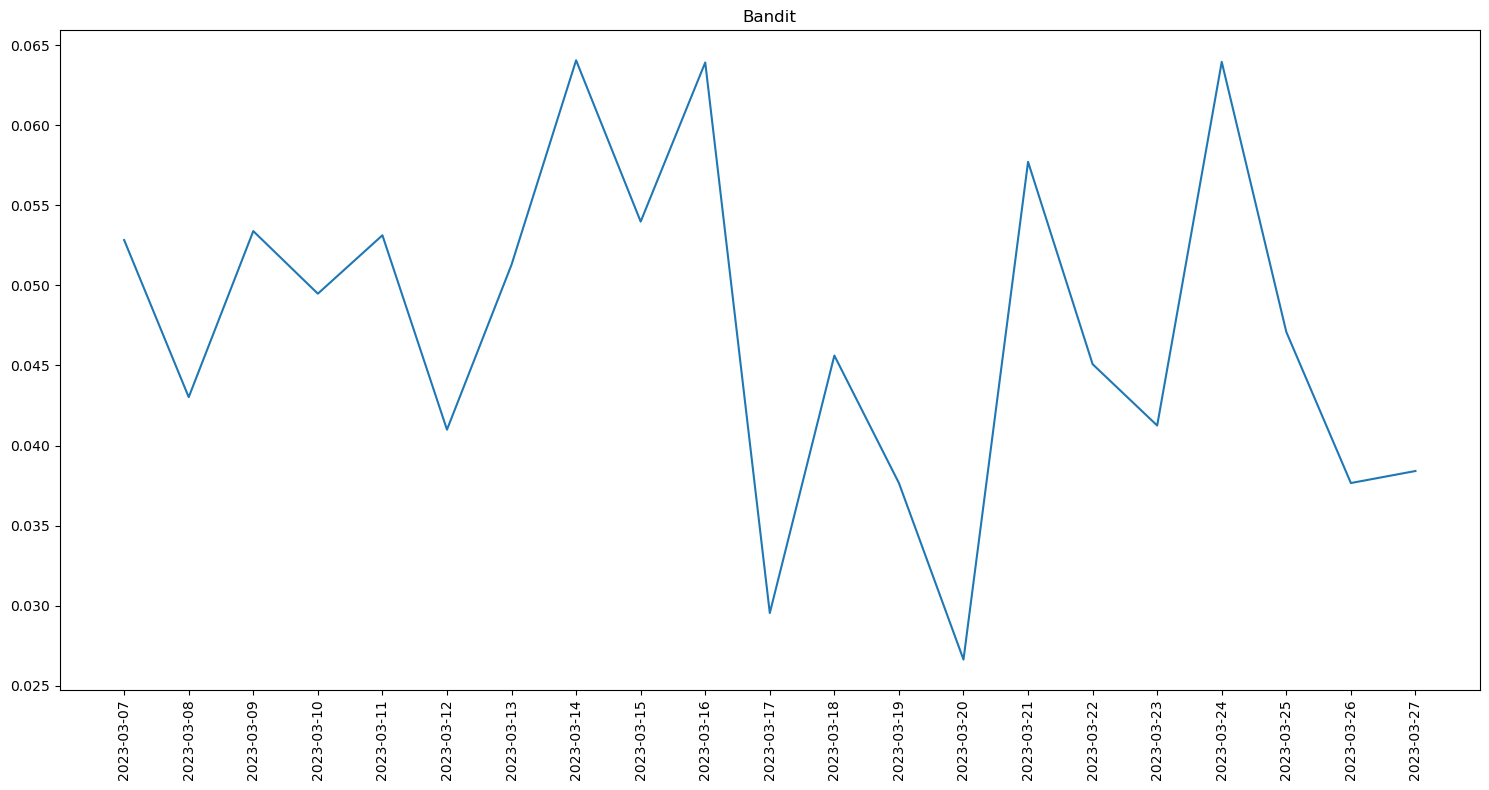

In [10]:
# bandit

fig = plt.figure(figsize=(15, 8))
bandit_inattentive_df_grouped = bandit_inattentive_df.groupby([bandit_inattentive_df['Date'].dt.date])['Inattention'].mean().reset_index()
bandit_inattentive_df_grouped['Date'] = pd.to_datetime(bandit_inattentive_df_grouped['Date'])
plt.plot(bandit_inattentive_df_grouped['Date'], bandit_inattentive_df_grouped['Inattention'])
# plt.plot(bandit_inattentive_df_grouped['Date'], bandit_inattentive_df_grouped['Inattention'] + np.std(bandit_inattentive_df_grouped['Inattention']), 'k--', alpha = 0.3)
# plt.plot(bandit_inattentive_df_grouped['Date'], bandit_inattentive_df_grouped['Inattention'] - np.std(bandit_inattentive_df_grouped['Inattention']), 'k--', alpha = 0.3)
plt.xticks(bandit_inattentive_df_grouped['Date'], rotation=90)
plt.title("Bandit")
fig.tight_layout()


### Days of the week (Monday = 0 ... Sunday = 6)

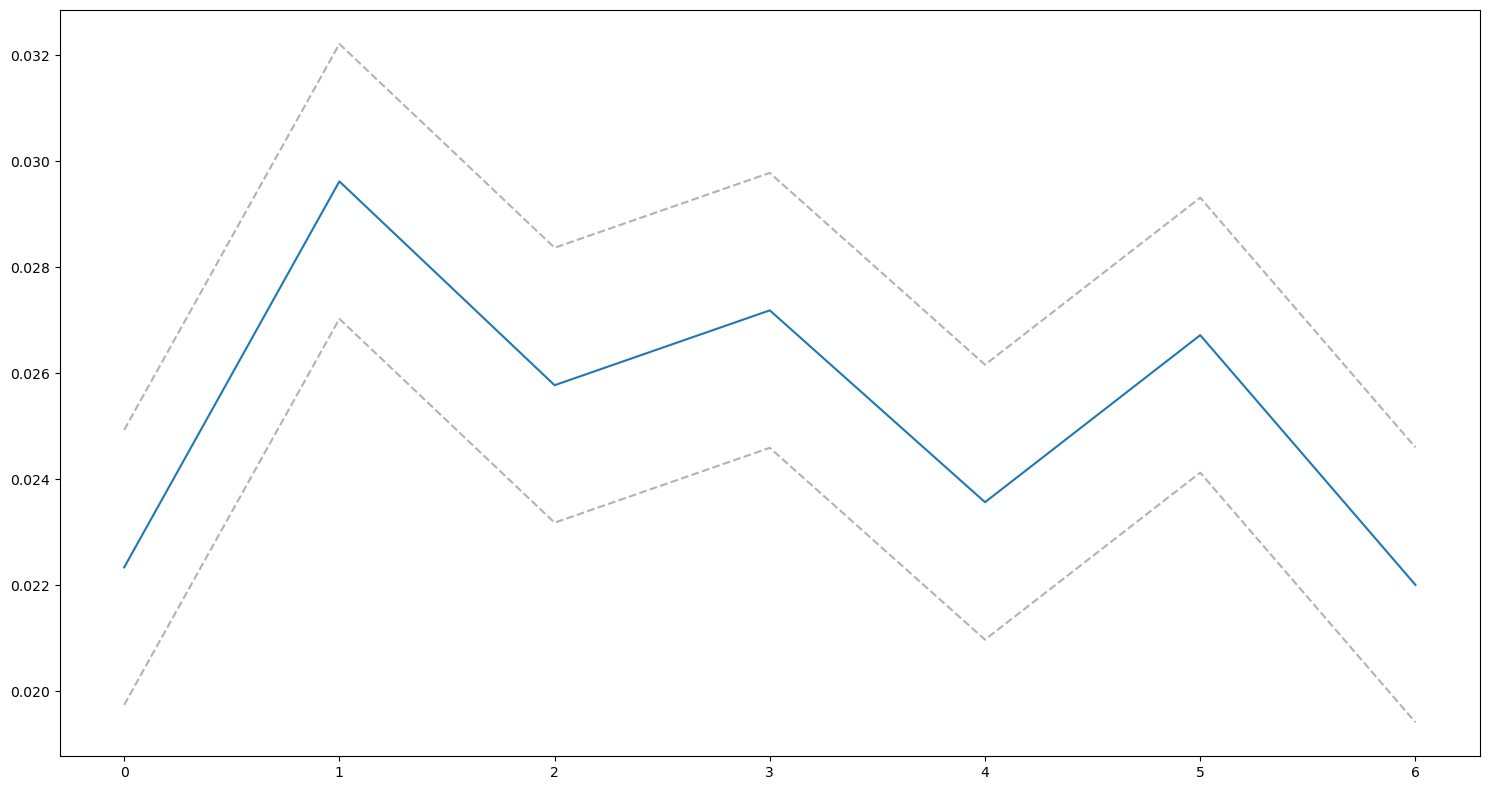

In [13]:
fig = plt.figure(figsize=(15, 8))

inattentive_df['Day'] = inattentive_df['Date'].dt.dayofweek
inattentive_df_grouped = inattentive_df.groupby([inattentive_df['Day']])['Inattention'].mean().reset_index()
plt.plot(inattentive_df_grouped['Day'], inattentive_df_grouped['Inattention'])
plt.plot(inattentive_df_grouped['Day'], inattentive_df_grouped['Inattention'] + np.std(inattentive_df_grouped['Inattention']), 'k--', alpha = 0.3)
plt.plot(inattentive_df_grouped['Day'], inattentive_df_grouped['Inattention'] - np.std(inattentive_df_grouped['Inattention']), 'k--', alpha = 0.3)
plt.xticks(inattentive_df_grouped['Day'])
fig.tight_layout()

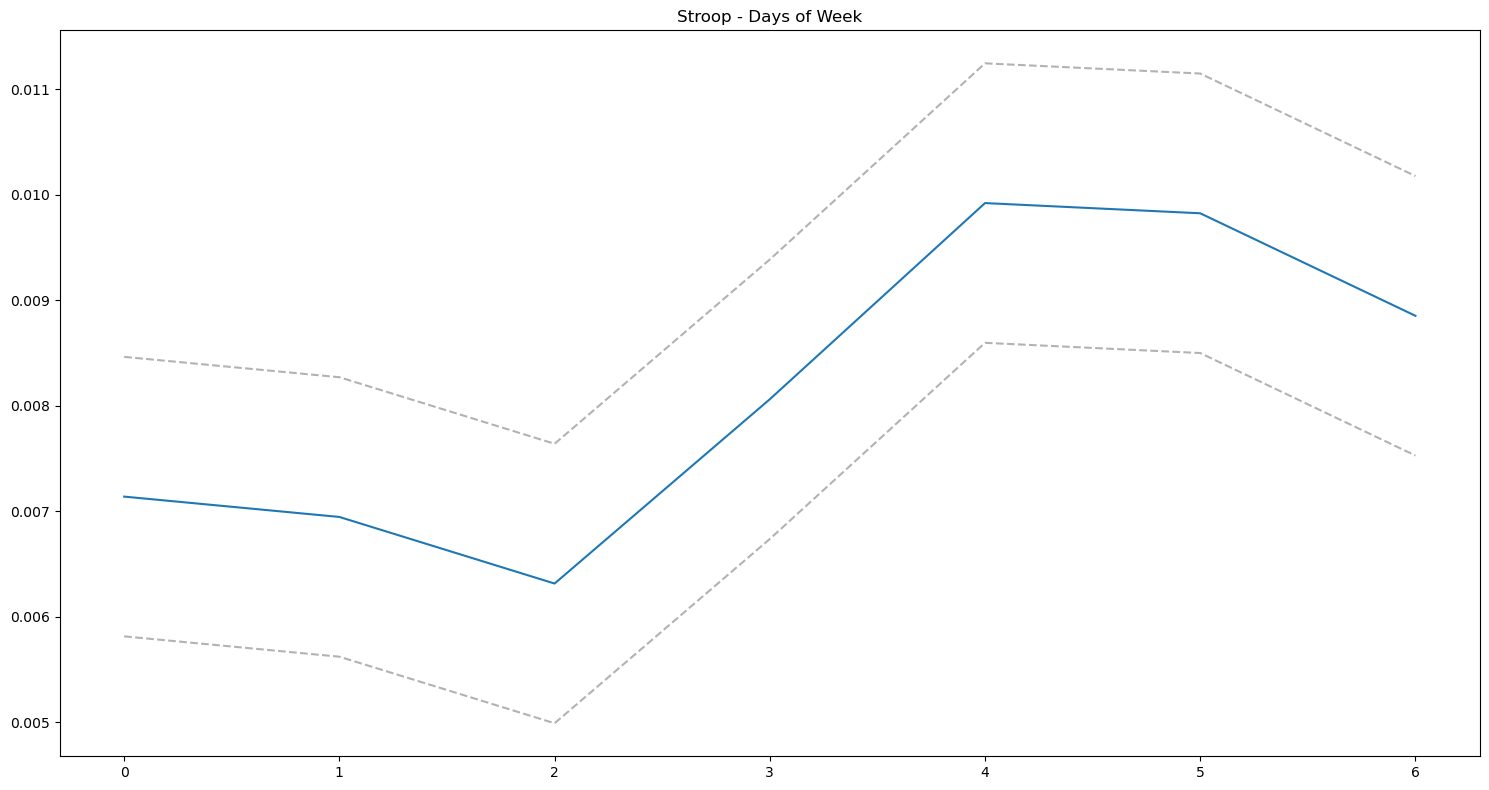

In [14]:
fig = plt.figure(figsize=(15, 8))

stroop_inattentive_df['Day'] = stroop_inattentive_df['Date'].dt.dayofweek
stroop_inattentive_df_grouped = stroop_inattentive_df.groupby([stroop_inattentive_df['Day']])['Inattention'].mean().reset_index()
plt.plot(stroop_inattentive_df_grouped['Day'], stroop_inattentive_df_grouped['Inattention'])
plt.plot(stroop_inattentive_df_grouped['Day'], stroop_inattentive_df_grouped['Inattention'] + np.std(stroop_inattentive_df_grouped['Inattention']), 'k--', alpha = 0.3)
plt.plot(stroop_inattentive_df_grouped['Day'], stroop_inattentive_df_grouped['Inattention'] - np.std(stroop_inattentive_df_grouped['Inattention']), 'k--', alpha = 0.3)
plt.xticks(stroop_inattentive_df_grouped['Day'])
plt.title("Stroop - Days of Week")
fig.tight_layout()

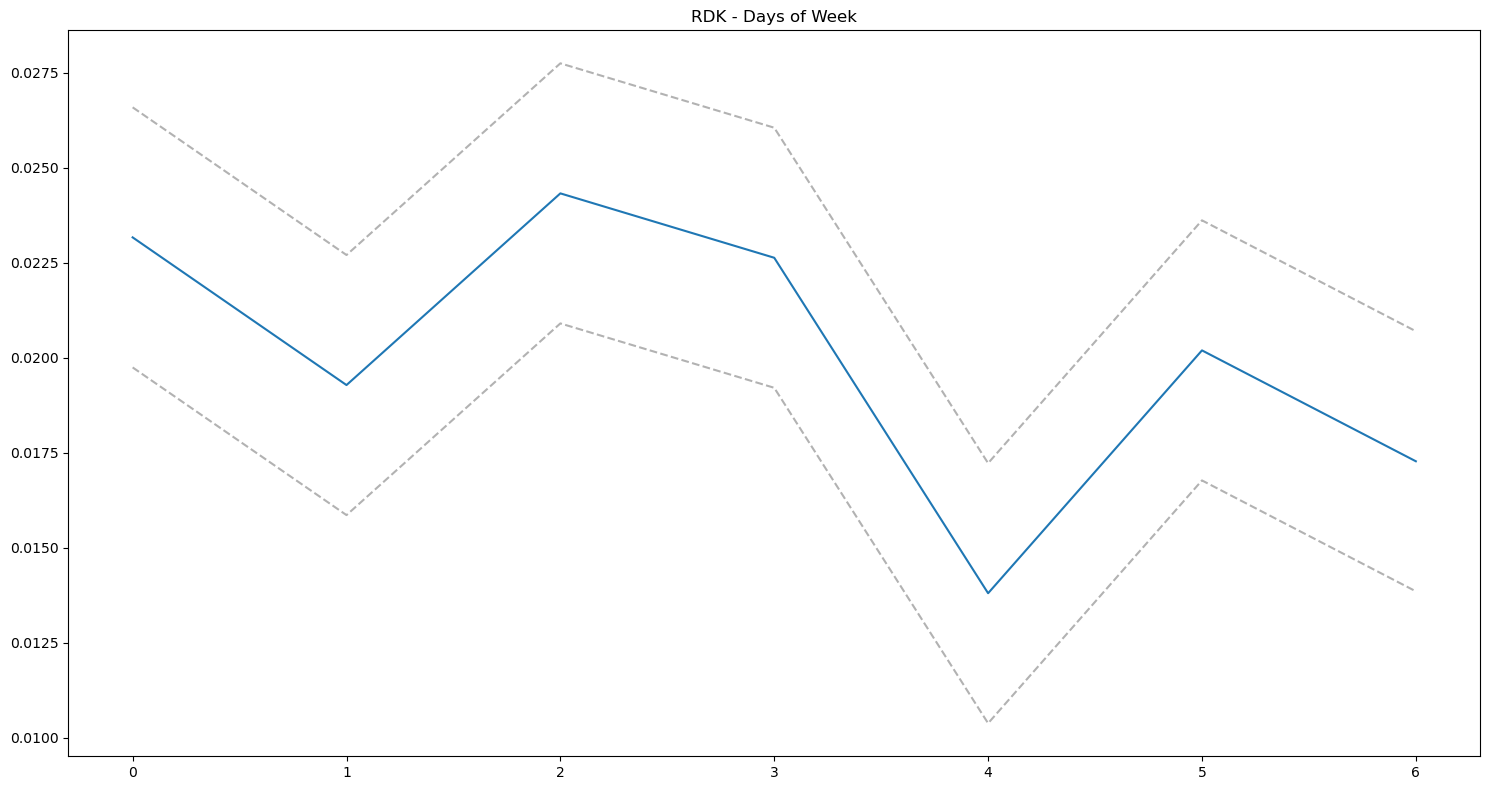

In [15]:
fig = plt.figure(figsize=(15, 8))

rdk_inattentive_df['Day'] = rdk_inattentive_df['Date'].dt.dayofweek
rdk_inattentive_df_grouped = rdk_inattentive_df.groupby([rdk_inattentive_df['Day']])['Inattention'].mean().reset_index()
plt.plot(rdk_inattentive_df_grouped['Day'], rdk_inattentive_df_grouped['Inattention'])
plt.plot(rdk_inattentive_df_grouped['Day'], rdk_inattentive_df_grouped['Inattention'] + np.std(rdk_inattentive_df_grouped['Inattention']), 'k--', alpha = 0.3)
plt.plot(rdk_inattentive_df_grouped['Day'], rdk_inattentive_df_grouped['Inattention'] - np.std(rdk_inattentive_df_grouped['Inattention']), 'k--', alpha = 0.3)

plt.xticks(rdk_inattentive_df_grouped['Day'])
plt.title("RDK - Days of Week")
fig.tight_layout()

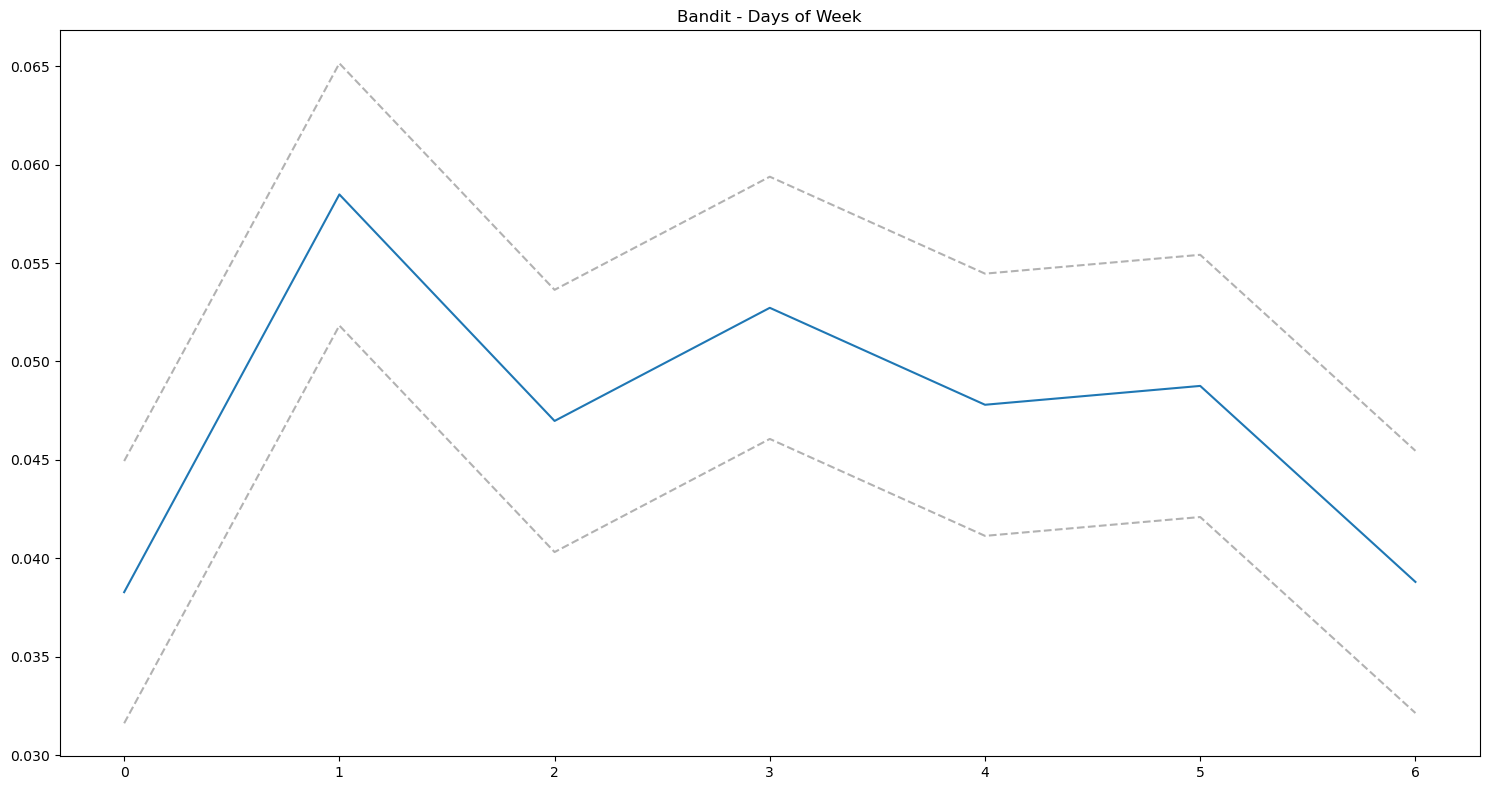

In [16]:
fig = plt.figure(figsize=(15, 8))

bandit_inattentive_df['Day'] = bandit_inattentive_df['Date'].dt.dayofweek
bandit_inattentive_df_grouped = bandit_inattentive_df.groupby([bandit_inattentive_df['Day']])['Inattention'].mean().reset_index()
plt.plot(bandit_inattentive_df_grouped['Day'], bandit_inattentive_df_grouped['Inattention'])
plt.plot(bandit_inattentive_df_grouped['Day'], bandit_inattentive_df_grouped['Inattention'] + np.std(bandit_inattentive_df_grouped['Inattention']), 'k--', alpha = 0.3)
plt.plot(bandit_inattentive_df_grouped['Day'], bandit_inattentive_df_grouped['Inattention'] - np.std(bandit_inattentive_df_grouped['Inattention']), 'k--', alpha = 0.3)
plt.xticks(bandit_inattentive_df_grouped['Day'])
plt.title("Bandit - Days of Week")
fig.tight_layout()

In [17]:
# recreating manip datasets

manip_1 = inattentive_df[inattentive_df["Manipulation"].str.contains("vanilla")][["Inattention", "Date"]]
manip_2 = inattentive_df[inattentive_df["Manipulation"].str.contains("progress")][["Inattention", "Date"]]
manip_3 = inattentive_df[inattentive_df["Manipulation"].str.contains("eyes")][["Inattention", "Date"]]
manip_4 = inattentive_df[inattentive_df["Manipulation"].str.contains("posneg")][["Inattention", "Date"]]
manip_5 = inattentive_df[inattentive_df["Manipulation"].str.contains("final")][["Inattention", "Date"]]
manip_6 = inattentive_df[inattentive_df["Manipulation"].str.contains("bonus")][["Inattention", "Date"]]
manip_7 = inattentive_df[inattentive_df["Manipulation"].str.contains("video")][["Inattention", "Date"]]

print(manip_3.head())

     Inattention                Date
157     0.001736 2023-03-07 10:23:50
158     0.000000 2023-03-08 10:02:57
159     0.008681 2023-03-07 10:21:55
160     0.003472 2023-03-07 10:20:07
161     0.003472 2023-03-07 10:15:31


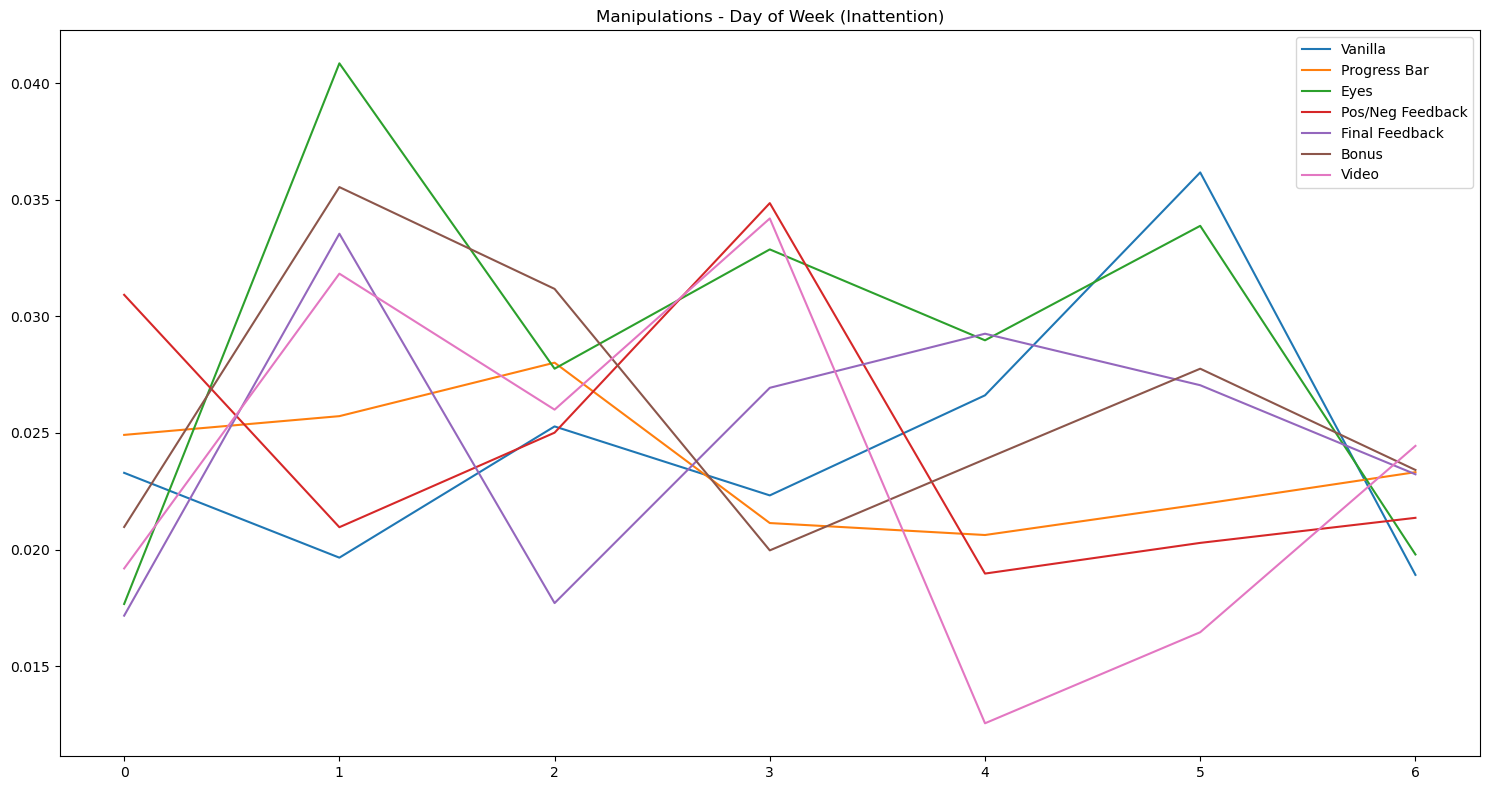

In [19]:
fig = plt.figure(figsize=(15, 8))

manip_1['Day'] = manip_1['Date'].dt.dayofweek
manip_1_grouped = manip_1.groupby([manip_1['Day']])['Inattention'].mean().reset_index()
plt.plot(manip_1_grouped['Day'], manip_1_grouped['Inattention'], label='Vanilla')
plt.xticks(manip_1_grouped['Day'])

manip_2['Day'] = manip_2['Date'].dt.dayofweek
manip_2_grouped = manip_2.groupby([manip_2['Day']])['Inattention'].mean().reset_index()
plt.plot(manip_2_grouped['Day'], manip_2_grouped['Inattention'], label='Progress Bar')
plt.xticks(manip_2_grouped['Day'])

manip_3['Day'] = manip_3['Date'].dt.dayofweek
manip_3_grouped = manip_3.groupby([manip_3['Day']])['Inattention'].mean().reset_index()
plt.plot(manip_3_grouped['Day'], manip_3_grouped['Inattention'], label='Eyes')
plt.xticks(manip_3_grouped['Day'])

manip_4['Day'] = manip_4['Date'].dt.dayofweek
manip_4_grouped = manip_4.groupby([manip_4['Day']])['Inattention'].mean().reset_index()
plt.plot(manip_4_grouped['Day'], manip_4_grouped['Inattention'], label='Pos/Neg Feedback')
plt.xticks(manip_4_grouped['Day'])

manip_5['Day'] = manip_5['Date'].dt.dayofweek
manip_5_grouped = manip_5.groupby([manip_5['Day']])['Inattention'].mean().reset_index()
plt.plot(manip_5_grouped['Day'], manip_5_grouped['Inattention'], label='Final Feedback')
plt.xticks(manip_5_grouped['Day'])

manip_6['Day'] = manip_6['Date'].dt.dayofweek
manip_6_grouped = manip_6.groupby([manip_6['Day']])['Inattention'].mean().reset_index()
plt.plot(manip_6_grouped['Day'], manip_6_grouped['Inattention'], label='Bonus')
plt.xticks(manip_6_grouped['Day'])

manip_7['Day'] = manip_7['Date'].dt.dayofweek
manip_7_grouped = manip_7.groupby([manip_7['Day']])['Inattention'].mean().reset_index()
plt.plot(manip_7_grouped['Day'], manip_7_grouped['Inattention'], label='Video')
plt.xticks(manip_7_grouped['Day'])

plt.title("Manipulations - Day of Week (Inattention)")
plt.legend()
fig.tight_layout()